<a href="https://colab.research.google.com/github/nuriaprol/PFG/blob/main/Analisis_y_modelado_ERCBRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerías

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from datetime import date
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

#Carga de datos


##Carga de BRP y Generadoras


In [88]:
datosBRP = pd.read_csv('datosBRP (1).csv', delimiter=';', decimal=',')

#Pasamos a numérico las columnas necesarias para hacer el análisis
datosBRP['cargo de regulación'] = pd.to_numeric(datosBRP['cargo de regulación'], errors='coerce')
datosBRP["desviacion por defecto"] = pd.to_numeric(datosBRP["desviacion por defecto"], errors="coerce")
datosBRP["desviacion por exceso"] = pd.to_numeric(datosBRP["desviacion por exceso"], errors="coerce")

#Desviación total es la suma de ambas desviaciones
datosBRP["desviacion total"] = datosBRP["desviacion por defecto"] + datosBRP["desviacion por exceso"]

datosBRP = datosBRP.dropna()
datosBRP.head()

AÑO  MES  Fecha_Prev  Hora   pool  desviacion por exceso  \
0  2024    3  14/03/2024     1  37.48                    0.0   
1  2024    3  14/03/2024     2  31.05                    0.0   
2  2024    3  14/03/2024     3  26.10                    0.0   
3  2024    3  14/03/2024     4  24.60                    0.0   
4  2024    3  14/03/2024     5  24.60                    0.0   

   desviacion por defecto  posicion final     conteo  cargo de regulación  \
0                1.041359            10.2  11.241359            23.885340   
1                1.355212             9.5  10.855212            48.104200   
2                1.199641             9.4  10.599641            22.918398   
3                1.156275             9.3  10.456275            49.182036   
4                1.229605             9.1  10.329605            90.555688   

   desviacion total  
0          1.041359  
1          1.355212  
2          1.199641  
3          1.156275  
4          1.229605

In [89]:
datos_generacion = pd.read_csv("Breakdown of Production_20240314_20250314.csv", sep=';', skiprows=1, header=1, encoding='utf-8')

datos_generacion = datos_generacion.dropna()
datos_generacion.head()

Date and Time   Hydro    Wind  Solar  Biomass  Wave  \
0  2024-03-14 00:00:00  5455.2  1509.1    0.1    372.8   0.0   
1  2024-03-14 00:15:00  5426.2  1558.1    0.1    372.8   0.0   
2  2024-03-14 00:30:00  5445.2  1548.2    0.1    369.3   0.0   
3  2024-03-14 00:45:00  5157.4  1586.6    0.1    369.1   0.0   
4  2024-03-14 01:00:00  5134.6  1673.6    0.0    372.4   0.0   

   Natural Gas - Combined Cycle  Natural Gas - Cogeneration  Coal  \
0                         937.6                       122.6   0.0   
1                         930.0                       104.5   0.0   
2                         930.0                       103.5   0.0   
3                         928.0                       104.6   0.0   
4                         936.0                        97.8   0.0   

   Other Thermal  Imports  Exports  Pumping  Battery Injection  \
0           31.6      0.0   2705.7      0.0                0.0   
1           32.0      0.0   2747.8      0.0                0.0   
2           31.0      0.0   2805.2      0.0                0.0   
3           31.1      0.0   2656.2      0.0                0.0   
4           31.4      0.0   2840.0      0.0                0.0   

   Battery Consumption  Consumption  
0                  0.0       5710.0  
1                  0.0       5665.0  
2                  0.0       5613.0  
3                  0.0       5511.3  
4                  0.0       5396.2

In [90]:
excluir = ["Consumption", "Date and Time"]

columnas_tecnologias = [
    col for col in datos_generacion.select_dtypes(include='number').columns if col not in excluir
]

# Si el dato está cada 15 minutos (0.25h), convierte MW a MWh
factor_tiempo = 0.25  # Está ya agrupados por hora, entonces dejamos el 1
energia_por_tecnologia = (datos_generacion[columnas_tecnologias].astype(float) * factor_tiempo).sum().sum()

# Total general
total_general = energia_por_tecnologia.sum()

consumo = datos_generacion["Consumption"].sum()

total_general, consumo

(np.float64(65384980.349999994), np.float64(207098662.70000002))

In [91]:
datosBRP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AÑO                     8784 non-null   int64  
 1   MES                     8784 non-null   int64  
 2   Fecha_Prev              8784 non-null   object 
 3   Hora                    8784 non-null   int64  
 4   pool                    8784 non-null   float64
 5   desviacion por exceso   8784 non-null   float64
 6   desviacion por defecto  8784 non-null   float64
 7   posicion final          8784 non-null   float64
 8   conteo                  8784 non-null   float64
 9   cargo de regulación     8784 non-null   float64
 10  desviacion total        8784 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 755.0+ KB


In [92]:
datos_generacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35136 entries, 0 to 35135
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date and Time                 35136 non-null  object 
 1   Hydro                         35136 non-null  float64
 2   Wind                          35136 non-null  float64
 3   Solar                         35136 non-null  float64
 4   Biomass                       35136 non-null  float64
 5   Wave                          35136 non-null  float64
 6   Natural Gas - Combined Cycle  35136 non-null  float64
 7   Natural Gas - Cogeneration    35136 non-null  float64
 8   Coal                          35136 non-null  float64
 9   Other Thermal                 35136 non-null  float64
 10  Imports                       35136 non-null  float64
 11  Exports                       35136 non-null  float64
 12  Pumping                       35136 non-null  float64
 13  B

##Unión BBDD


Se van a unir las bases de datos para poder trabajar con solo una variables. Primero es necesario pasar la base de datos de generación de cuartohoraria a horaria. Al tratarse de potencia (MW) los valores no se deben sumar si no calcular la potencia media de esa hora.

In [93]:
#Obtener mismo formato que la base de datos DatosBRP
datos_generacion["Date and Time"] = pd.to_datetime(datos_generacion["Date and Time"])

#Se extraen la fecha y la hora
datos_generacion["Fecha_Prev"] = datos_generacion["Date and Time"].dt.date
datos_generacion["Hora"] = datos_generacion["Date and Time"].dt.hour + 1 #La hora 1 corresponde de 00:00 a 00:59
datos_generacion["Fecha_Prev"] = pd.to_datetime(datos_generacion["Fecha_Prev"]).dt.strftime("%-d/%-m/%Y")

#Se agrupan por fecha y hora para pasar de formato cuartohorario a horario
#Se hace la media porque están en MW y no en MWh, por lo que así obtenemos la potencia media por hora.
datos_generacion = datos_generacion.groupby(["Fecha_Prev", "Hora"]).mean(numeric_only=True).reset_index()

# Eliminar columna original
if "Date and Time" in datos_generacion.columns:
    datos_generacion = datos_generacion.drop(columns=["Date and Time"])

# Convertir de string a datetime, asumiendo que el formato original es día/mes/año
datos_generacion["Fecha_Prev"] = pd.to_datetime(datos_generacion["Fecha_Prev"], dayfirst=True)

# Luego convertir a string en formato 14/03/2024
datos_generacion["Fecha_Prev"] = datos_generacion["Fecha_Prev"].dt.strftime("%d/%m/%Y")

Buscamos obtener 8784 registros porque estamos trabajando del 14/03/2024 al 14/03/2025, son 365 días más 1 más por estar el 14 dos veces.
Entonces 24h x 366d = 8784 registros

In [94]:
len(datos_generacion)

8783

In [95]:
len(datosBRP)

8784

Hay un dato faltante en datos generación, probamos a ver si es la hora 2 del 31 de marzo de 2024, que fue cuando se realizo el cambio horario de verano, donde se pasó de la 1am directamente a las 3am

In [96]:
# Buscar el dato del 31/03/2024 y hora 2 (Cambia de hora verano)
dato_buscado = datos_generacion[(datos_generacion["Fecha_Prev"] == pd.to_datetime("2024-03-31").date()) &
                           (datos_generacion["Hora"] == 2)]

dato_buscado

Empty DataFrame
Columns: [Fecha_Prev, Hora, Hydro, Wind, Solar, Biomass, Wave, Natural Gas - Combined Cycle, Natural Gas - Cogeneration, Coal, Other Thermal, Imports, Exports, Pumping, Battery Injection, Battery Consumption, Consumption]
Index: []

Pata completar este dato y tener los mismos registros en ambas bases de datos, se completará la hora 2 faltante con la media de la hora 1 y la hora 3.

In [97]:
# Filtrar horas 1 y 3 del 31 de marzo de 2024
h1 = datos_generacion[(datos_generacion["Fecha_Prev"] == "31/03/2024") & (datos_generacion["Hora"] == 1)]
h3 = datos_generacion[(datos_generacion["Fecha_Prev"] == "31/03/2024") & (datos_generacion["Hora"] == 3)]

#Calcular la media entre las dos filas (sin tocar Fecha_Prev ni Hora)
media_valores = (h1.iloc[0, 2:] + h3.iloc[0, 2:]) / 2

# Crear nueva fila copiando de una de las existentes
nueva_fila = h1.copy()
nueva_fila["Hora"] = 2
nueva_fila.iloc[0, 2:] = media_valores

# Añadir al DataFrame original
datos_generacion = pd.concat([datos_generacion, nueva_fila], ignore_index=True)

# Reordenar por fecha y hora
datos_generacion = datos_generacion.sort_values(by=["Fecha_Prev", "Hora"]).reset_index(drop=True)
len(datos_generacion)


8784

Como se había tomado en cuenta el cambio de hora de veano buscamos también ek de invierno, donde a las 3:00 de la madrugada, los relojes se atrasaron una hora, volviendo a marcar las 2:00. Ocasionando así la hora 25 de ese día

In [98]:
dato_buscado = datosBRP[(datosBRP["Fecha_Prev"] == "27/10/2024")]
#& (datosBRP["Hora"] == 25)]
dato_buscado

AÑO  MES  Fecha_Prev  Hora    pool  desviacion por exceso  \
5447  2024   10  27/10/2024     1   87.71               0.000000   
5448  2024   10  27/10/2024     2   83.31              -0.358745   
5449  2024   10  27/10/2024     3   82.23              -0.238096   
5450  2024   10  27/10/2024     4   80.68              -0.378583   
5451  2024   10  27/10/2024     5   81.30              -0.184095   
5452  2024   10  27/10/2024     6   80.68              -0.035927   
5453  2024   10  27/10/2024     7   70.00              -0.115700   
5454  2024   10  27/10/2024     8   80.00              -0.387356   
5455  2024   10  27/10/2024     9   86.24              -0.420200   
5456  2024   10  27/10/2024    10   81.30              -0.415997   
5457  2024   10  27/10/2024    11   64.36              -0.401021   
5458  2024   10  27/10/2024    12   54.72              -0.241573   
5459  2024   10  27/10/2024    13   42.50              -0.155057   
5460  2024   10  27/10/2024    14   39.99               0.000000   
5461  2024   10  27/10/2024    15   40.00              -0.094329   
5462  2024   10  27/10/2024    16   55.19               0.000000   
5463  2024   10  27/10/2024    17   44.99               0.000000   
5464  2024   10  27/10/2024    18   63.97               0.000000   
5465  2024   10  27/10/2024    19   81.25               0.000000   
5466  2024   10  27/10/2024    20   96.27              -0.173875   
5467  2024   10  27/10/2024    21  128.70               0.000000   
5468  2024   10  27/10/2024    22  115.51               0.000000   
5469  2024   10  27/10/2024    23  107.36              -0.082098   
5470  2024   10  27/10/2024    24   90.58              -0.309545   
5471  2024   10  27/10/2024    25  102.99              -0.332976   

      desviacion por defecto  posicion final    conteo  cargo de regulación  \
5447                0.071764             7.9  7.971764            34.486304   
5448                0.000000             8.2  7.841255            28.873516   
5449                0.000000             8.0  7.761904            37.691494   
5450                0.000000             7.9  7.521417            52.403481   
5451                0.000000             7.8  7.615905            85.318962   
5452                0.000000             7.6  7.564073            33.774576   
5453                0.000000             7.6  7.484300            23.149636   
5454                0.000000             7.9  7.512644            42.730193   
5455                0.000000             8.2  7.779800            15.178041   
5456                0.000000             8.0  7.584003            15.755749   
5457                0.000000             7.9  7.498979           137.767238   
5458                0.000000             7.6  7.358427           100.414976   
5459                0.000000             7.6  7.444943           101.794241   
5460                0.023053             7.4  7.423053           134.376833   
5461                0.000000             7.5  7.405671            71.116621   
5462                0.189532             7.2  7.389532           103.213446   
5463                0.058406             7.3  7.358406           133.246627   
5464                0.183087             7.3  7.483087           125.270795   
5465                0.188363             7.4  7.588363           128.102344   
5466                0.000000             8.0  7.826125            78.940016   
5467                0.200598             8.0  8.200598            89.215216   
5468                0.082038             8.0  8.082038            68.907647   
5469                0.000000             8.3  8.217902            47.722849   
5470                0.000000             8.4  8.090455            88.462115   
5471                0.000000             8.4  8.067024           108.917732   

      desviacion total  
5447          0.071764  
5448         -0.358745  
5449         -0.238096  
5450         -0.378583  
5451         -0.184095  
5452         -0.035927  
5453    

In [99]:
datosBRP = datosBRP[~((datosBRP["Fecha_Prev"] =="27/10/2024") & (datosBRP["Hora"] == 25))]

In [100]:
# Filtrar las filas de interés
h1 = datosBRP[(datosBRP["Fecha_Prev"] == "31/03/2024") & (datosBRP["Hora"] == 23)]
h3 = datosBRP[(datosBRP["Fecha_Prev"] == "01/04/2024") & (datosBRP["Hora"] == 1)]

if not h1.empty and not h3.empty:
    # Convertir columnas numéricas para el cálculo
    vals1 = pd.to_numeric(h1.iloc[0, 2:], errors='coerce')
    vals2 = pd.to_numeric(h3.iloc[0, 2:], errors='coerce')
    media_valores = (vals1 + vals2) / 2

    # Crear la nueva fila con la media
    nueva_fila = h1.copy()
    nueva_fila["Hora"] = 24
    nueva_fila.iloc[0, 2:] = media_valores

    # Añadir al DataFrame original
    datosBRP = pd.concat([datosBRP, nueva_fila], ignore_index=True)
    datosBRP = datosBRP.sort_values(by=["Fecha_Prev", "Hora"]).reset_index(drop=True)
    print("Fila interpolada agregada correctamente.")
else:
    print("No se encontraron ambas filas necesarias para interpolar.")


Fila interpolada agregada correctamente.


In [101]:
len(datos_generacion), len(datosBRP)

(8784, 8784)

In [102]:
# Corregir formato inconsistente en datosBRP
datosBRP["Fecha_Prev"] = pd.to_datetime(datosBRP["Fecha_Prev"], format="mixed", dayfirst=True).dt.strftime("%d/%m/%Y")
datos_generacion["Fecha_Prev"] = pd.to_datetime(datos_generacion["Fecha_Prev"], format="mixed", dayfirst=True).dt.strftime("%d/%m/%Y")


# Hacer el merge
df_unido = datosBRP.merge(datos_generacion, on=["Fecha_Prev", "Hora"], how="inner")
print(len(df_unido))


8783


In [103]:
df_unido.head()

AÑO  MES  Fecha_Prev  Hora  pool  desviacion por exceso  \
0  2024    4  01/04/2024     1  0.70                    0.0   
1  2024    4  01/04/2024     2  0.02                    0.0   
2  2024    4  01/04/2024     3  0.00                    0.0   
3  2024    4  01/04/2024     4  0.00                    0.0   
4  2024    4  01/04/2024     5  0.00                    0.0   

   desviacion por defecto  posicion final    conteo  cargo de regulación  ...  \
0                0.712569             7.7  8.412569            35.389413  ...   
1                1.388064             7.4  8.788064            62.449457  ...   
2                0.808237             8.2  9.008237            57.612066  ...   
3                0.836599             8.2  9.036599            67.625273  ...   
4                0.902841             8.1  9.002841            76.295976  ...   

   Natural Gas - Combined Cycle  Natural Gas - Cogeneration  Coal  \
0                           0.0                     106.925   0.0   
1                           0.0                     108.550   0.0   
2                           0.0                     107.775   0.0   
3                           0.0                     106.275   0.0   
4                           0.0                     101.300   0.0   

   Other Thermal  Imports  Exports   Pumping  Battery Injection  \
0         26.350      0.0  455.200  1178.800                0.0   
1         25.950      0.0  181.225  1398.225                0.0   
2         25.525      0.0   92.675  1555.925                0.0   
3         23.900      0.0  388.275  1877.450                0.0   
4         21.125      0.0  630.100  1875.425                0.0   

   Battery Consumption  Consumption  
0                  0.0     5031.575  
1                  0.0     4677.675  
2                  0.0     4483.725  
3                  0.0     4351.050  
4                  0.0     4158.325  

[5 rows x 26 columns]

Vamos a hacer ahora la suma total de todas las columnas para ver si hay alguna columna que no tenga valores y eliminarla.

In [104]:
try:
    resumen_sumas = df_unido.select_dtypes(include='number').sum().to_frame(name="Suma_total")
except NameError:
    resumen_sumas = pd.DataFrame({"Error": ["df_unido no está definido. Ejecuta el merge primero."]})

print(resumen_sumas)

                                Suma_total
AÑO                           1.777854e+07
MES                           5.723700e+04
Hora                          1.097760e+05
pool                          6.395717e+05
desviacion por exceso        -4.108900e+03
desviacion por defecto        4.677740e+03
posicion final                8.671010e+04
conteo                        8.727894e+04
cargo de regulación           8.430250e+05
desviacion total              5.688399e+02
Hydro                         1.762952e+07
Wind                          1.402289e+07
Solar                         5.063002e+06
Biomass                       3.070477e+06
Wave                          0.000000e+00
Natural Gas - Combined Cycle  3.660139e+06
Natural Gas - Cogeneration    1.449083e+06
Coal                          0.000000e+00
Other Thermal                 2.479335e+05
Imports                       1.348960e+07
Exports                       2.086557e+06
Pumping                       4.657285e+06
Battery Inj

Tanto wave como coal tiene potencia 0 durante todo el año por lo que no son relevantes y las eliminamos.

In [105]:
df_unido = df_unido.drop(columns=["Wave", "Coal"], errors="ignore")

#ANÁLISIS EXPLORATORIO


##Distribuciones

Para comenzar con el análisis exploratorio de los datos disponibles, se procede al estudio de las distribuciones empíricas de cinco variables clave dentro del sistema eléctrico: "pool" (precio del mercado mayorista), "conteo" (energía programada), "posición final" (energía realmente consumida), "desviación total" (diferencia entre lo programado y lo consumido), y "cargo de regulación" (coste imputado por la activación de reservas del sistema).

Este análisis tiene como objetivo identificar el comportamiento estadístico de cada variable, detectar la presencia de valores extremos (outliers) y comprender las posibles relaciones entre ellas. A través de representaciones gráficas como histogramas y diagramas de caja (boxplots), se observará el grado de simetría,  y sesgo de las distribuciones.

En particular, la variable "cargo de regulación" será objeto de especial atención, ya que representa la variable objetivo del análisis. Su alta variabilidad y la presencia de valores atípicos negativos requieren un tratamiento estadístico cuidadoso para no distorsionar los modelos y obtener interpretaciones robustas sobre los factores que inciden en su evolución.





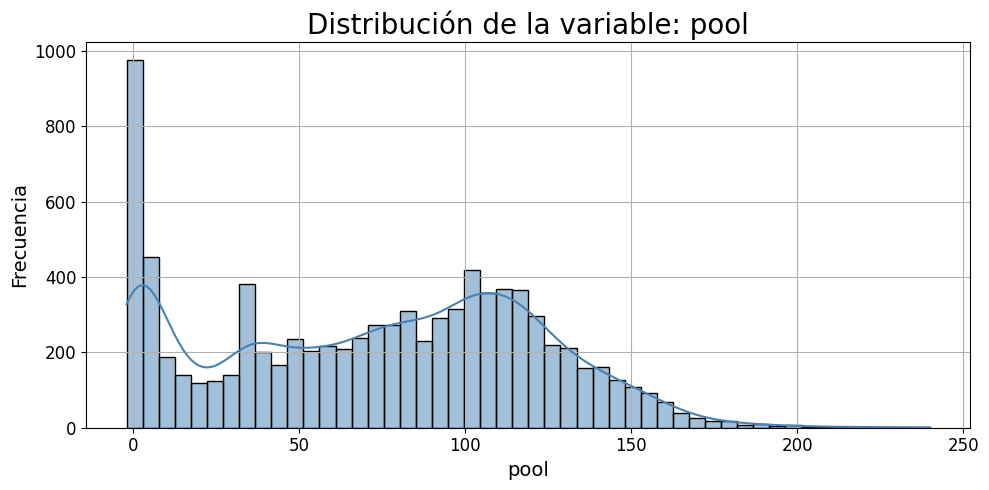

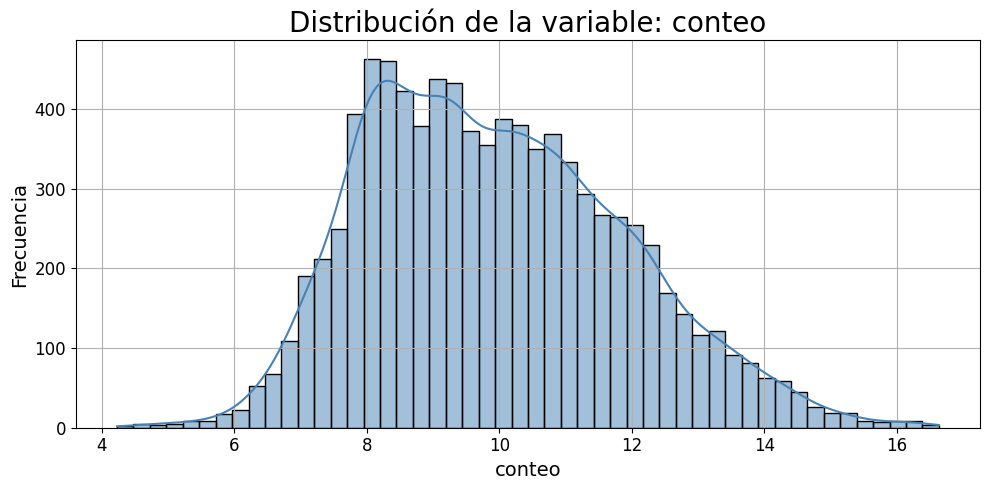

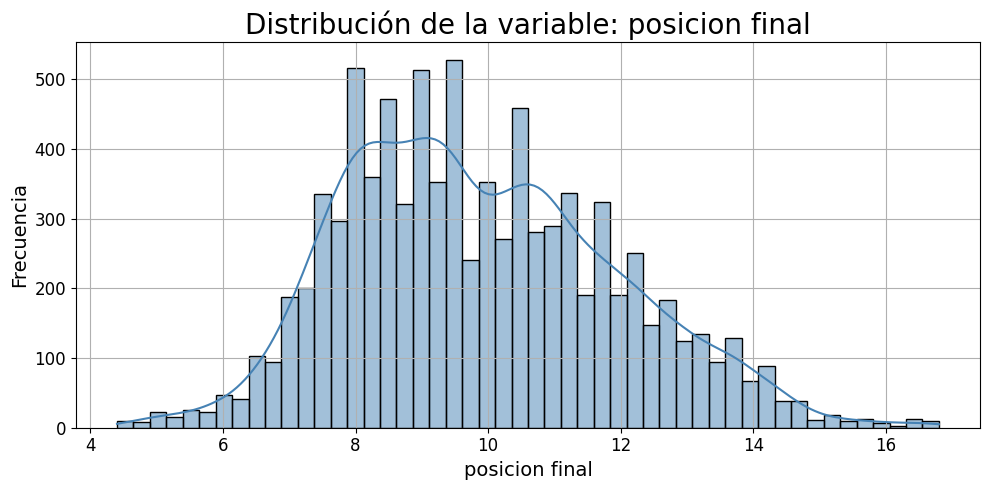

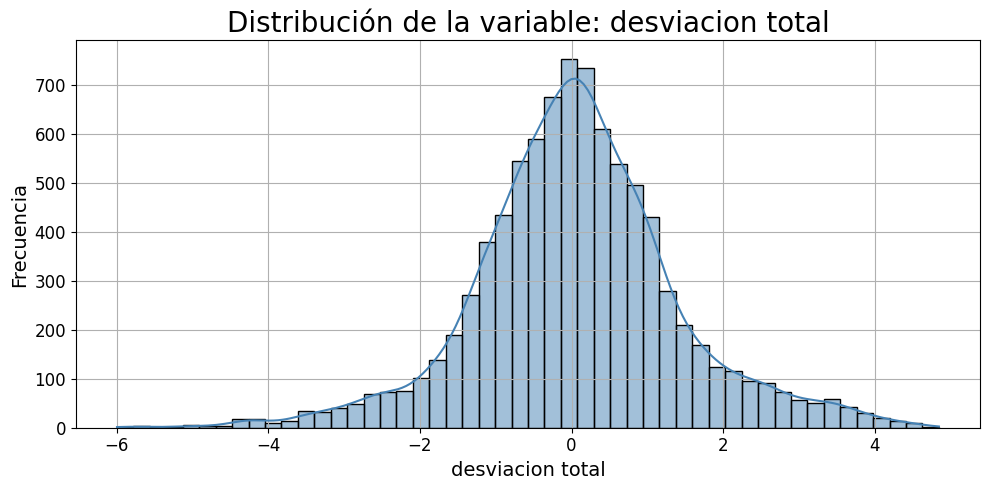

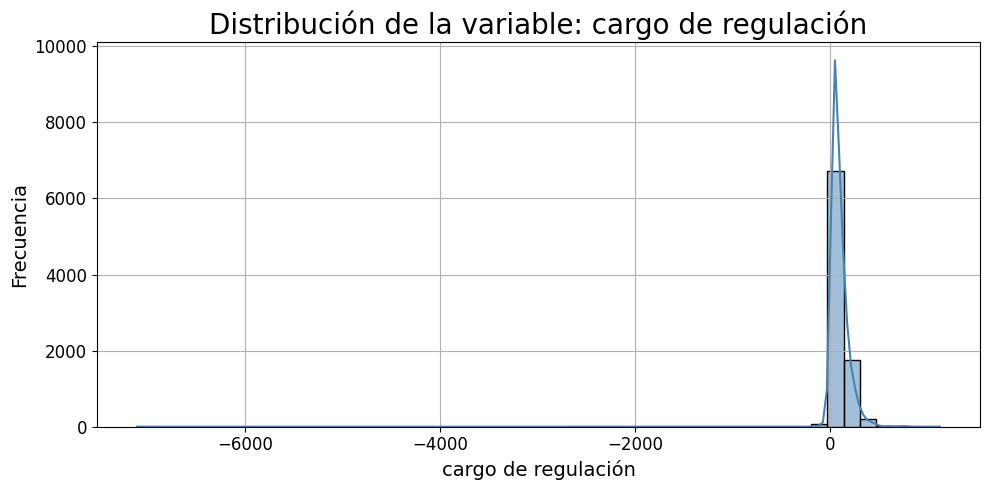

In [106]:
# Lista de variables a analizar
variables_a_estudiar = [
    "pool",
    "conteo",
    "posicion final",
    "desviacion total",
    "cargo de regulación"
]

# Histograma + curva de densidad con seaborn
for var in variables_a_estudiar:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_unido[var], kde=True, bins=50, color="steelblue", edgecolor='black')
    plt.title(f"Distribución de la variable: {var}", fontsize=20)
    plt.xlabel(var, fontsize=14)
    plt.ylabel("Frecuencia", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


El precio del pool presenta una distribución asimétrica hacia la derecha, con valores bajos predominantes y picos puntuales que superan los 200 €/MWh, típicos de tensiones entre oferta y demanda.
La variable conteo muestra una distribución estable y moderadamente dispersa, mientras que la posición final presenta mayor variabilidad, lo que indica diferencias entre lo programado y lo realmente consumido.
La desviación total sigue una distribución aproximadamente simétrica centrada en cero, coherente con un sistema donde los desvíos tienden a compensarse.
En cambio, el cargo de regulación presenta una distribución fuertemente asimétrica con valores atípicos negativos muy extremos, lo que requiere un tratamiento específico de outliers para evitar distorsiones en el análisis.

##Boxplots y outliers
A partir de los diagramas de caja (boxplots), es posible visualizar con mayor claridad la presencia, cantidad y ubicación de los valores atípicos en las diferentes variables analizadas.

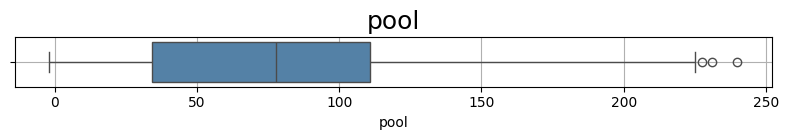

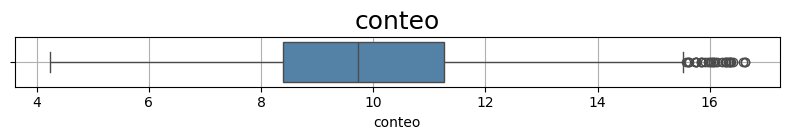

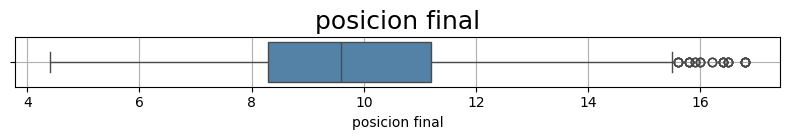

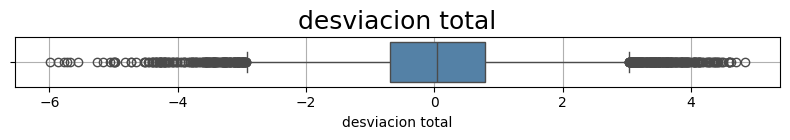

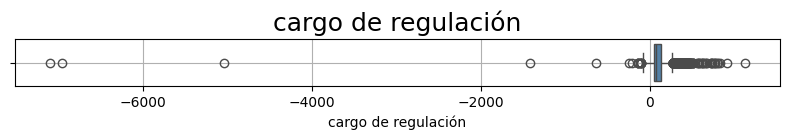

In [107]:
#Boxplots de las variables seleccionadas
for var in variables_a_estudiar:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=datosBRP[var], color="steelblue")
    plt.title(f"{var}", fontsize=18)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Dado que estos datos han sido contrastados con otras fuentes y se ha verificado su validez, no se procederá a eliminarlos del análisis.

In [108]:
# Cálculo de IQR
Q1 = df_unido["cargo de regulación"].quantile(0.25)
Q3 = df_unido["cargo de regulación"].quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df_unido[(df_unido["cargo de regulación"] < limite_inferior) |
                    (df_unido["cargo de regulación"] > limite_superior)]

print(f"Número total de registros: {len(df_unido)}")
print(f"Número de outliers detectados: {len(outliers)}")
print(f"Porcentaje de outliers: {100 * len(outliers) / len(df_unido):.2f}%")

# Mostrar los 10 valores más bajos y más altos
outliers_extremos_ordenados = pd.concat([
    outliers.nsmallest(10, "cargo de regulación"),
    outliers.nlargest(10, "cargo de regulación")
])
print(outliers_extremos_ordenados)


Número total de registros: 8783
Número de outliers detectados: 414
Porcentaje de outliers: 4.71%
       AÑO  MES  Fecha_Prev  Hora    pool  desviacion por exceso  \
1512  2024    4  08/04/2024     1    1.33              -0.403974   
21    2024    4  01/04/2024    22   21.43               0.000000   
6309  2024    9  24/09/2024    22  138.44               0.000000   
6308  2024    9  24/09/2024    21  140.00               0.000000   
7920  2024    3  30/03/2024     1   10.60               0.000000   
4232  2025    1  17/01/2025     9  161.32               0.000000   
2880  2024    4  13/04/2024     1   24.15               0.000000   
1698  2024   11  08/11/2024    19  133.58              -0.093822   
7694  2024    7  29/07/2024    15   99.09               0.000000   
662   2024    4  04/04/2024    15    0.00              -1.015523   
3838  2024    5  16/05/2024    23  106.39              -1.634458   
3381  2024   10  14/10/2024    22  128.90              -1.347549   
2052  2024    5  10

Los registros que se encuentran fuera de estos umbrales fueron clasificados como valores atípicos. Como resultado, se identificaron 414 outliers de un total de 8784 observaciones, lo que equivale aproximadamente al 4.71% del conjunto de datos.

El análisis de los 10 valores extremos del “cargo de regulación” revela que muchos coinciden con festivos, fines de semana o franjas nocturnas de baja generación renovable. Estos factores parecen contribuir a desequilibrios en el sistema, reforzando la hipótesis de que condiciones externas influyen en la aparición de estos picos atípicos.

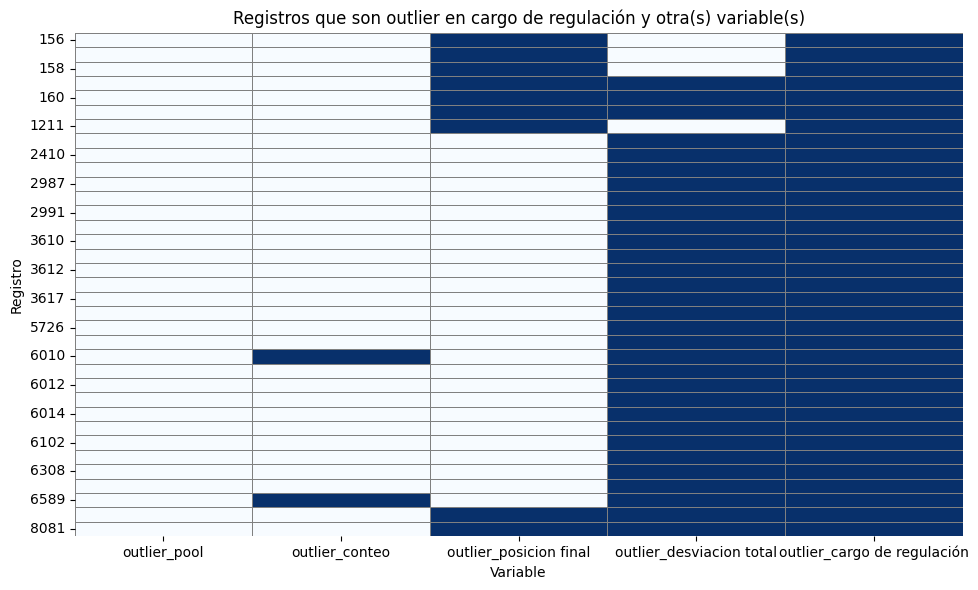

In [109]:
df_outliers = df_unido.copy()

# Función para identificar outliers por IQR
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return (serie < lim_inf) | (serie > lim_sup)

# Aplicar función para cada variable
for var in variables_a_estudiar:
    df_outliers[f"outlier_{var}"] = detectar_outliers_iqr(df_outliers[var])

# Calcular número total de outliers por fila
cols_outliers = [f"outlier_{v}" for v in variables_a_estudiar]
df_outliers["n_outliers"] = df_outliers[cols_outliers].sum(axis=1)

# Filtrar
df_cargo_outliers = df_outliers[df_outliers["outlier_cargo de regulación"] == True]
df_cargo_y_otro = df_cargo_outliers[df_cargo_outliers["n_outliers"] > 1]

df_heat = df_cargo_y_otro[cols_outliers].head(73)
plt.figure(figsize=(10, 6))
sns.heatmap(df_heat.astype(int), cmap="Blues", cbar=False, linewidths=0.5, linecolor="gray")
plt.title("Registros que son outlier en cargo de regulación y otra(s) variable(s)")
plt.xlabel("Variable")
plt.ylabel("Registro")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Esta representación permite detectar coincidencias relevantes entre outliers multivariables. El análisis muestra que varios registros que presentan valores atípicos en el cargo de regulación también los muestran en desviación total y algunos en la posición final.

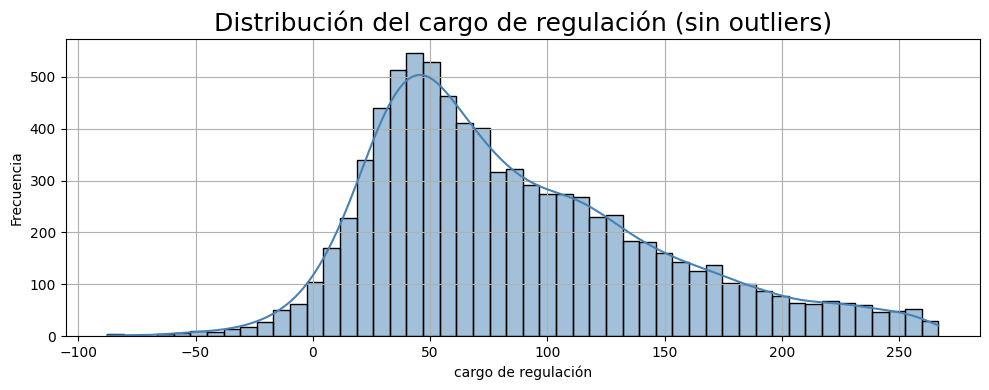

In [110]:
#Filtrar
datos_sin_outliers = df_unido[(df_unido["cargo de regulación"] >= limite_inferior) &
                               (df_unido["cargo de regulación"] <= limite_superior)]

#distribución sin outliers
plt.figure(figsize=(10, 4))
sns.histplot(datos_sin_outliers["cargo de regulación"], kde=True, bins=50, color="steelblue")
plt.title("Distribución del cargo de regulación (sin outliers)",fontsize=18)
plt.xlabel("cargo de regulación")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


Una vez excluidos dichos outliers, con el fin de entender mejor el comportamiento del resto de los datos se vuelve a graficar la distribución. La distribución presenta una clara asimetría positiva (sesgo a la derecha), concentrando la mayor parte de los valores en torno a los 40-60 euros

## Identificación de patrones diarios o estacionales

In [111]:
columnas_excluir = ["AÑO", "MES", "Hora"]
df_numerico = df_unido.select_dtypes(include='number').drop(columns=columnas_excluir, errors="ignore")

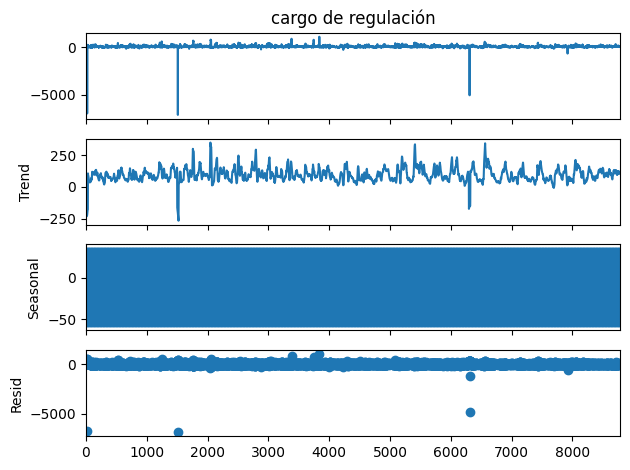

In [112]:
result = seasonal_decompose(df_numerico["cargo de regulación"], model="additive", period=24)
result.plot()
plt.show()

Dado que al aplicar la descomposición sobre la serie completa no se apreciaban con claridad los ciclos recurrentes, se optó por trabajar con los primeros 200 registros, lo cual permite aislar mejor los patrones de corta duración, como las fluctuaciones diarias.

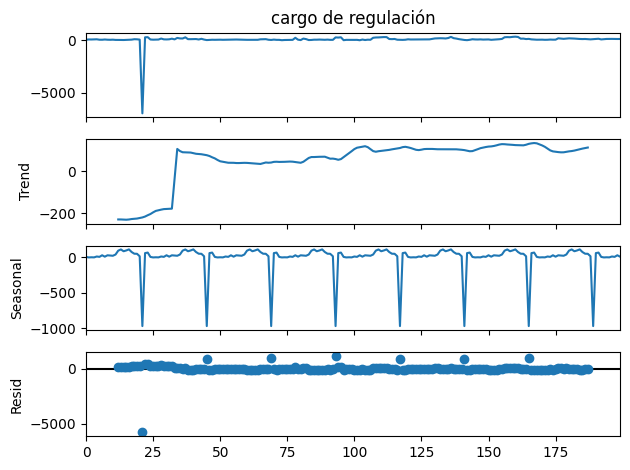

In [113]:
# Se toman los primeros 200 registros
df_numerico_subset = df_numerico.iloc[:200].copy()
df_numerico_subset["cargo de regulación"] = pd.to_numeric(df_numerico_subset["cargo de regulación"], errors='coerce')

# Descomposición estacional
result = seasonal_decompose(df_numerico_subset["cargo de regulación"], model="additive", period=24)

# Visualizar
result.plot()
plt.show()

Dado este resultado, se toma la decisión de agrupar la base de datos por hora con el objetivo de estudiar cómo se relacionan entre sí las diferentes variables a lo largo del ciclo diario. Esta agrupación permite observar el comportamiento promedio de cada variable en función de la hora del día, lo cual resulta especialmente relevante en sistemas energéticos donde la demanda y la generación suelen seguir patrones horarios

##Agrupación por hora
Agrupo por hora pasando de tener miles de datos a únicamente 24 por columna, Calculo la media por hora de todos los datos.



In [114]:
columnas_excluir = ["AÑO", "MES", "Hora"]
try:
    # Agrupar por hora
    suma_por_hora = df_unido.groupby("Hora").mean(numeric_only=True).reset_index()

    # Ordenar por hora por si acaso
    suma_por_hora = suma_por_hora.sort_values("Hora").reset_index(drop=True)

except NameError:
    suma_por_hora = pd.DataFrame({"Error": ["df_unido no está definido."]})

df_numerico_por_hora = suma_por_hora.select_dtypes(include='number').drop(columns=columnas_excluir, errors="ignore")

In [115]:
suma_por_hora

Hora          AÑO       MES        pool  desviacion por exceso  \
0      1  2024.199454  6.516393   81.874781              -0.403152   
1      2  2024.199454  6.516393   75.689781              -0.375120   
2      3  2024.199454  6.516393   71.915929              -0.365363   
3      4  2024.199454  6.516393   69.896557              -0.375408   
4      5  2024.199454  6.516393   68.225000              -0.379700   
5      6  2024.199454  6.516393   70.346721              -0.376166   
6      7  2024.199454  6.516393   77.634262              -0.368770   
7      8  2024.199454  6.516393   88.983770              -0.374730   
8      9  2024.199454  6.516393   89.775301              -0.427294   
9     10  2024.199454  6.516393   75.708497              -0.487871   
10    11  2024.199454  6.516393   60.789016              -0.549406   
11    12  2024.199454  6.516393   51.896913              -0.560027   
12    13  2024.199454  6.516393   48.265710              -0.575430   
13    14  2024.199454  6.516393   45.880273              -0.594147   
14    15  2024.199454  6.516393   44.175929              -0.606051   
15    16  2024.199454  6.516393   45.322350              -0.594378   
16    17  2024.199454  6.516393   50.992787              -0.582627   
17    18  2024.199454  6.516393   62.574536              -0.512715   
18    19  2024.199454  6.516393   77.573443              -0.485358   
19    20  2024.199454  6.516393   93.814126              -0.483443   
20    21  2024.199454  6.516393  103.740929              -0.450193   
21    22  2024.199454  6.516393  106.404672              -0.429233   
22    23  2024.199454  6.516393   97.756011              -0.442990   
23    24  2024.200000  6.526027   88.468000              -0.428101   

    desviacion por defecto  posicion final     conteo  cargo de regulación  \
0                 0.498403        9.480055   9.575305            57.424210   
1                 0.537932        9.229235   9.392047            87.032990   
2                 0.531796        9.137432   9.303864            90.067615   
3                 0.519753        8.977049   9.121395            94.257622   
4                 0.517146        8.941530   9.078976            95.470027   
5                 0.505416        8.977049   9.106299            96.069656   
6                 0.486200        9.057377   9.174808            93.229382   
7                 0.496456        9.668852   9.790579            80.899406   
8                 0.513944       10.263115  10.349765            80.334124   
9                 0.517850       10.917760  10.947739            88.168772   
10                0.564829       10.909563  10.924986           113.252865   
11                0.595565       10.451639  10.487178           115.481416   
12                0.608123       10.248087  10.280781           120.175890   
13                0.604746        9.706557   9.717156           123.559136   
14                0.569030        9.784699   9.747679           125.919663   
15                0.572005       10.082240  10.059868           127.218595   
16                0.537470       10.233880  10.188722           132.186689   
17                0.521494       10.377596  10.386374           126.940318   
18                0.521871       10.354918  10.391431           106.074087   
19                0.544645       10.152732  10.213935            88.673579   
20                0.531254       10.117213  10.198274            63.854613   
21                0.507221       10.065847  10.143835            36.560130   
22                0.491233       10.050546  10.098789            79.875441   
23                0.487661        9.754521   9.814081            80.841745   

    desviacion total  ...     Biomass  Natural Gas - Combined Cycle  \
0           0.095251  ...  351.712432                    347.515027   
1           0.162812  ...  351.201434                    349.509563   
2           0.166433  ...  351.415779                    352.272131   
3           0.1443

##Matriz de correlación

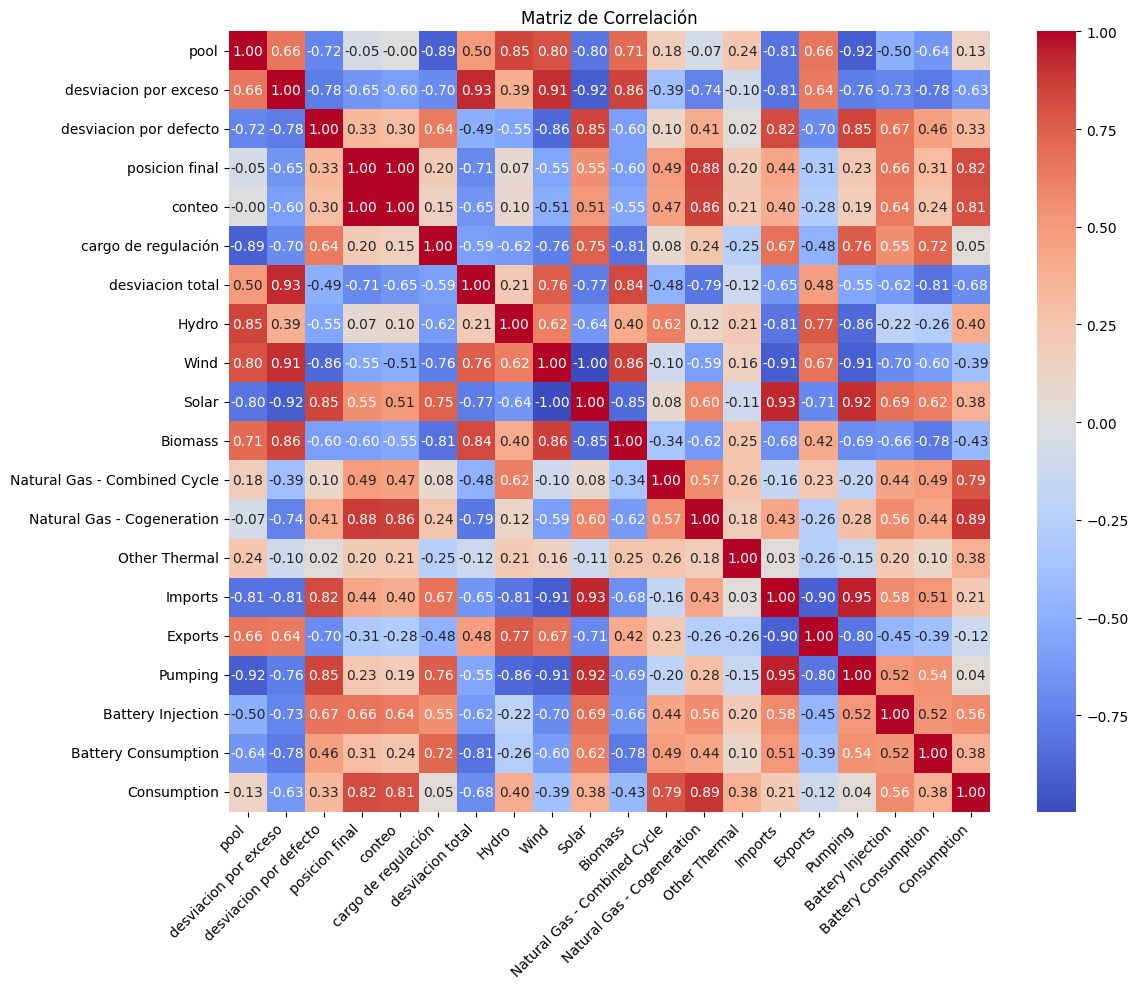

In [116]:
# Calcular la matriz de correlación
correlation_matrix = df_numerico_por_hora.corr()

# Crear el mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [117]:
#Orden de mayor a menor en valor absoluto
correlaciones_charges = correlation_matrix['cargo de regulación'].sort_values(key=lambda x: x.abs(), ascending=False)
correlaciones_charges

cargo de regulación             1.000000
pool                           -0.894942
Biomass                        -0.809857
Pumping                         0.762874
Wind                           -0.759602
Solar                           0.747394
Battery Consumption             0.724173
desviacion por exceso          -0.699340
Imports                         0.673858
desviacion por defecto          0.638209
Hydro                          -0.616482
desviacion total               -0.594067
Battery Injection               0.553193
Exports                        -0.475987
Other Thermal                  -0.251201
Natural Gas - Cogeneration      0.244770
posicion final                  0.203606
conteo                          0.152666
Natural Gas - Combined Cycle    0.078540
Consumption                     0.045634
Name: cargo de regulación, dtype: float64

Estos resultados son consistentes con las hipótesis iniciales del estudio, que planteaban que tanto el comportamiento del mercado eléctrico (representado por el pool) como la participación de energías renovables tienen una influencia directa en los costes regulatorios. En efecto, tres de las cinco variables más correlacionadas son tecnologías renovables.

##Gráficos para entender posibles relaciones


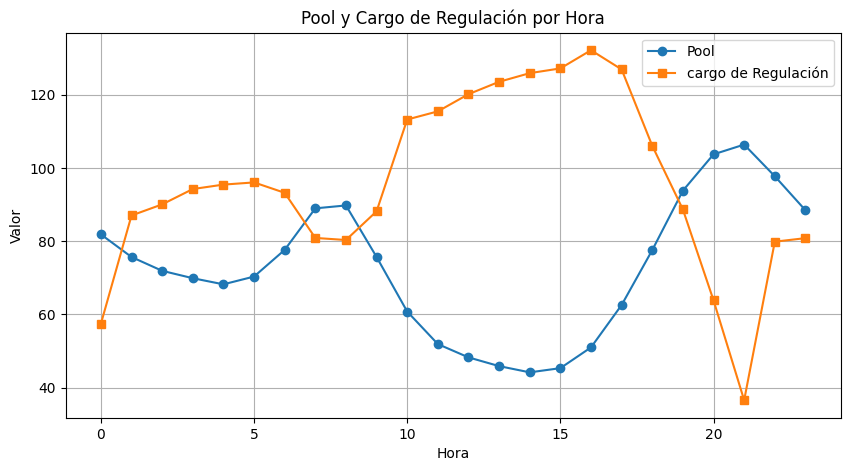

In [118]:
# Gráfico 1: Pool y Cargo de Regulación
plt.figure(figsize=(10, 5))
plt.plot(suma_por_hora.index, suma_por_hora["pool"], label="Pool", marker='o')
plt.plot(suma_por_hora.index, suma_por_hora["cargo de regulación"], label="cargo de Regulación", marker='s')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.title("Pool y Cargo de Regulación por Hora")
plt.legend()
plt.grid(True)
plt.show()


El precio del pool tiende a ser más bajo durante las horas centrales del día (aproximadamente entre las 11:00 y las 17:00), coincidiendo con una mayor penetración de energía solar, mientras que alcanza sus máximos en las horas nocturnas (alrededor de las 21:00). Por el contrario, el cargo de regulación muestra un patrón opuesto, con valores más altos en las horas diurnas y una caída pronunciada al anochecer. Este comportamiento refuerza la correlación negativa detectada entre ambas variables y sugiere que cuando el precio del mercado es bajo, posiblemente debido a una alta generación renovable, se incrementan los desvíos o la necesidad de ajustes, lo que da lugar a mayores costes regulatorios.

In [119]:
#PORCENTAJES TOTALES POR GENERADORA

excluir = [
    "pool", "desviacion por exceso", "desviacion por defecto",
    "posicion final", "conteo", "cargo de regulación", "AÑO", "MES",
    "Hora", "Consumption", "desviacion total"
]

columnas_tecnologias = [
    col for col in df_unido.select_dtypes(include='number').columns if col not in excluir
]
# Si el dato está cada 15 minutos (0.25h), convierte MW a MWh
factor_tiempo = 1  # Está ya agrupados por hora, entonces dejamos el 1
energia_por_tecnologia = (df_unido[columnas_tecnologias].astype(float) * factor_tiempo).sum()

# Total general
total_general = energia_por_tecnologia.sum()

#porcentajes reales de generación
porcentajes = (energia_por_tecnologia / total_general) * 100

df_porcentajes = porcentajes.reset_index()
df_porcentajes.columns = ['Tecnología', 'Porcentaje (%)']
df_porcentajes = df_porcentajes.sort_values(by='Porcentaje (%)', ascending=False)

print(df_porcentajes)
print(f"Suma total: {df_porcentajes['Porcentaje (%)'].sum():.5f}%")

                      Tecnología  Porcentaje (%)
0                          Hydro       26.966131
1                           Wind       21.449420
7                        Imports       20.633704
2                          Solar        7.744372
9                        Pumping        7.123786
4   Natural Gas - Combined Cycle        5.598551
3                        Biomass        4.696603
8                        Exports        3.191599
5     Natural Gas - Cogeneration        2.216518
6                  Other Thermal        0.379239
11           Battery Consumption        0.000046
10             Battery Injection        0.000031
Suma total: 100.00000%


Aunque el porcentaje total por tecnología generadora permite tener una visión general de la composición del mix energético gestionado por REN, este enfoque resulta limitado para extraer conclusiones precisas. Para comprender realmente la dinámica del sistema y su impacto en variables como el cargo de regulación, es más útil analizar la distribución porcentual por generadora a lo largo del día, ya que permite identificar patrones horarios y posibles correlaciones con eventos específicos del mercado eléctrico.



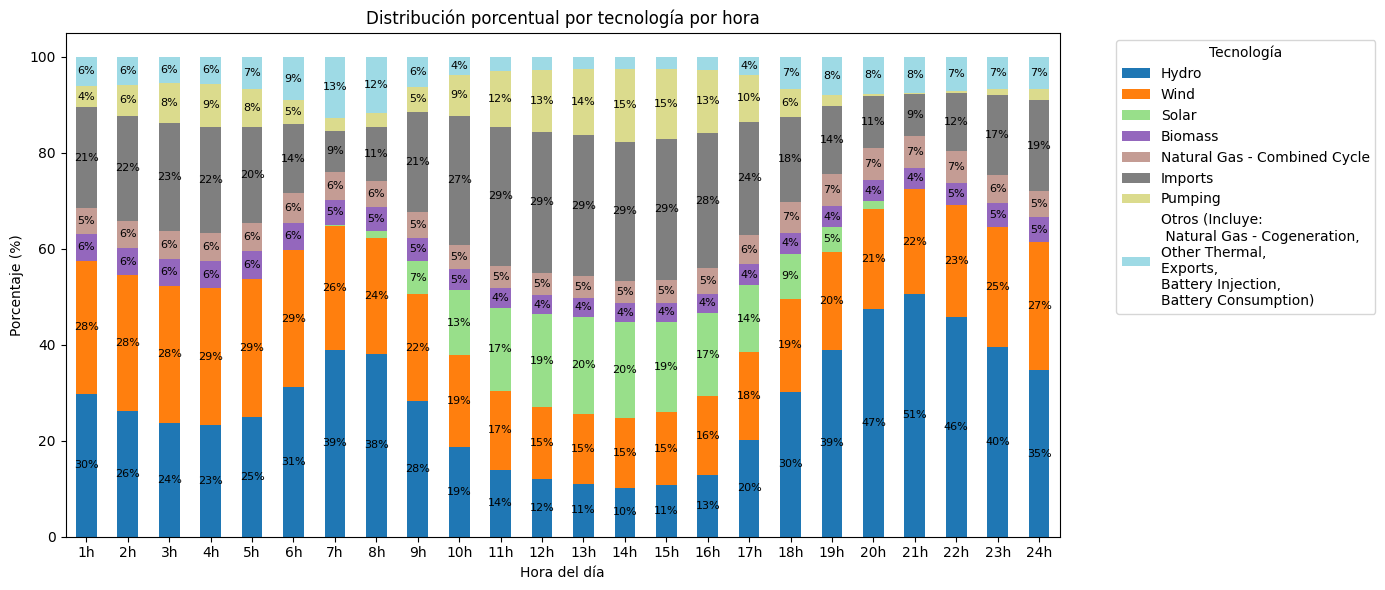

In [120]:
#Gráfico 2: Distribución porcentual por tecnología

excluir = [
    "pool", "desviacion por exceso", "desviacion por defecto",
    "posicion final", "conteo", "cargo de regulación", "AÑO", "MES",
    "Hora", "Consumption", "desviacion total"
] #DatosBRP

columnas_tecnologias = [col for col in suma_por_hora.columns if col not in excluir]
df_tecnologias = suma_por_hora[columnas_tecnologias].copy()

totales = df_tecnologias.sum()
umbral = 0.04 * totales.sum() #Se van a agrupar las teconologías por porcentajes menores a 4%
tecnologias_principales = totales[totales >= umbral].index.tolist()
tecnologias_otros = [col for col in df_tecnologias.columns if col not in tecnologias_principales]

df_apilado = df_tecnologias.copy()
df_apilado["Otros"] = df_apilado[tecnologias_otros].sum(axis=1)
df_apilado = df_apilado[tecnologias_principales + ["Otros"]]

df_porcentual = df_apilado.div(df_apilado.sum(axis=1), axis=0) * 100


fig, ax = plt.subplots(figsize=(14, 6))
bars = df_porcentual.plot(kind='bar', stacked=True, cmap='tab20', ax=ax)

# Etiquetas personalizadas del eje X
#Horas de la 1 a la 24
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h+1}h' for h in range(24)], rotation=0)

# Títulos y etiquetas
ax.set_title('Distribución porcentual por tecnología por hora')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Porcentaje (%)')

# Leyenda con explicación de "Otros"
handles, labels = ax.get_legend_handles_labels()
otros_texto = ", \n".join(tecnologias_otros)
labels = [
    f"{l} (Incluye:\n {otros_texto})" if l == "Otros" else l
    for l in labels
]
ax.legend(handles, labels, title='Tecnología', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir porcentajes encima de cada segmento
for idx, row in df_porcentual.iterrows():
    y_offset = 0
    for col in df_porcentual.columns:
        height = row[col]
        if height > 3:  # solo mostrar etiquetas >3% para no saturar
            ax.text(idx, y_offset + height / 2, f'{height:.0f}%', ha='center', va='center', fontsize=8)
        y_offset += height

plt.tight_layout()
plt.show()


Aunque la biomasa muestra alta correlación con el cargo de regulación, su baja y constante participación la hace poco representativa.

Destaca la fuerte dependencia de Portugal de la electricidad importada desde España durante las horas solares.

La energía solar, al tener prioridad en el mercado, desplaza a otras tecnologías como la eólica e hidráulica, siendo esta última utilizada como respaldo en momentos de baja producción renovable.

In [121]:
#Gráfico 4: Representación de todas las energías acumuladas, acomodadas de menor a mayor variabilidad

# Seleccionamos columnas numéricas, excluyendo las variables no deseadas
excluir = ["pool", "desviacion por exceso", "desviacion por defecto",
               "posicion final", "conteo", "cargo de regulación", "AÑO", "MES", "Hora", "Consumption", "desviacion total"]
columnas_usar = [col for col in suma_por_hora.select_dtypes(include='number').columns if col not in excluir]

datos_filtrados = suma_por_hora[columnas_usar]

# Calcular variabilidad por columna
variabilidad = datos_filtrados.std().sort_values()
columnas_ordenadas = variabilidad.index.tolist()
datos_ordenados = datos_filtrados[columnas_ordenadas]

# gráfico de área apilada
fig = go.Figure()

for col in columnas_ordenadas:
    fig.add_trace(go.Scatter(
        x=suma_por_hora.index,
        y=datos_ordenados[col],
        mode='lines',
        stackgroup='one',
        name=col
    ))

    # Línea negra: total por fila
fig.add_trace(go.Scatter(
    x=suma_por_hora.index,
    y=datos_ordenados.sum(axis=1),
    mode='lines',
    name='Total Generación',
    line=dict(color='black', width=2)
))

fig.update_layout(
    title="Generación Horaria (ordenado por variabilidad)",
    xaxis_title="Índice (Hora)",
    yaxis_title="MW",
    template="plotly_white",
    legend_title="Variable"
    )

fig.show()


Este gráfico apilado muestra la generación horaria de electricidad desglosada por tipo de tecnología, ordenada por su variabilidad a lo largo del día.

El gráfico refleja un uso intensivo de energía solar e importaciones durante el día, mientras que la hidráulica y otras tecnologías compensan la generación en horas sin sol. Este comportamiento es coherente con un sistema energético que prioriza renovables, pero que aún depende de intercambios internacionales y fuentes de respaldo regulables.

In [122]:
#Gráfico 5: Comparativa entre generación por tecnología y cargo de regulación.

variables_apiladas = ["Biomass", "Hydro","Wind", "Solar", "Imports"]

# Columnas numéricas para total generación (excluye no generadoras)
excluir = ["pool", "desviacion por exceso", "desviacion por defecto",
           "posicion final", "conteo", "cargo de regulación", "AÑO", "MES",
           "Hora", "Consumption", "desviacion total"]
columnas_generadoras = [col for col in suma_por_hora.select_dtypes(include='number').columns if col not in excluir]

# Datos de generación y precios
datos_apilados = suma_por_hora[variables_apiladas]
total_generacion = suma_por_hora[columnas_generadoras].sum(axis=1)
precio_regulacion = suma_por_hora["cargo de regulación"]

fig = go.Figure()

# Área apilada (ordenada)
for col in variables_apiladas:
    fig.add_trace(go.Scatter(
        x=suma_por_hora.index,
        y=datos_apilados[col],
        mode='lines',
        stackgroup='one',
        name=col
    ))

# Línea de total de generación
fig.add_trace(go.Scatter(
    x=suma_por_hora.index,
    y=total_generacion,#PROBAR CON CONSUMPTION
    #y=total_generacion,
    mode='lines',
    name='Total Generación',
    line=dict(color='black', width=2, dash='solid')
))

# Línea de cargo de regulación
fig.add_trace(go.Scatter(
    x=suma_por_hora.index,
    y=precio_regulacion,
    mode='lines',
    name='Cargo de Regulación',
    line=dict(color='red', width=2.5),
    yaxis="y2"
))

# Ejes y layout ajustados para evitar solapamiento
fig.update_layout(
    title="Generación Horaria (Biomasa, Eólica, Solar, Hidraulica, Importaciones) y Precio de Cargo de Regulación",
    xaxis_title="Hora",
    yaxis=dict(
        title="MW",
        side="left"
    ),
    yaxis2=dict(
        title="Precio Cargo de Regulación",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        bgcolor='rgba(255,255,255,0)',
        bordercolor='rgba(0,0,0,0)'
    ),
    margin=dict(r=160, t=80),
    legend_title="Variable"
)


Se elaboró una visualización que muestra la generación horaria por tecnología junto al cargo de regulación. La curva del cargo (en rojo) alcanza su máximo durante las horas solares (12:00–15:00), lo que sugiere que la intermitencia de la energía fotovoltaica incrementa la necesidad de ajustes. En cambio, durante la noche, con fuentes más estables como hidráulica e importaciones, el cargo disminuye notablemente. Esto indica que un mix energético con alta presencia de renovables no gestionables puede elevar los costes regulatorios si no se acompaña de tecnologías de respaldo, como hemos visto continuamente.

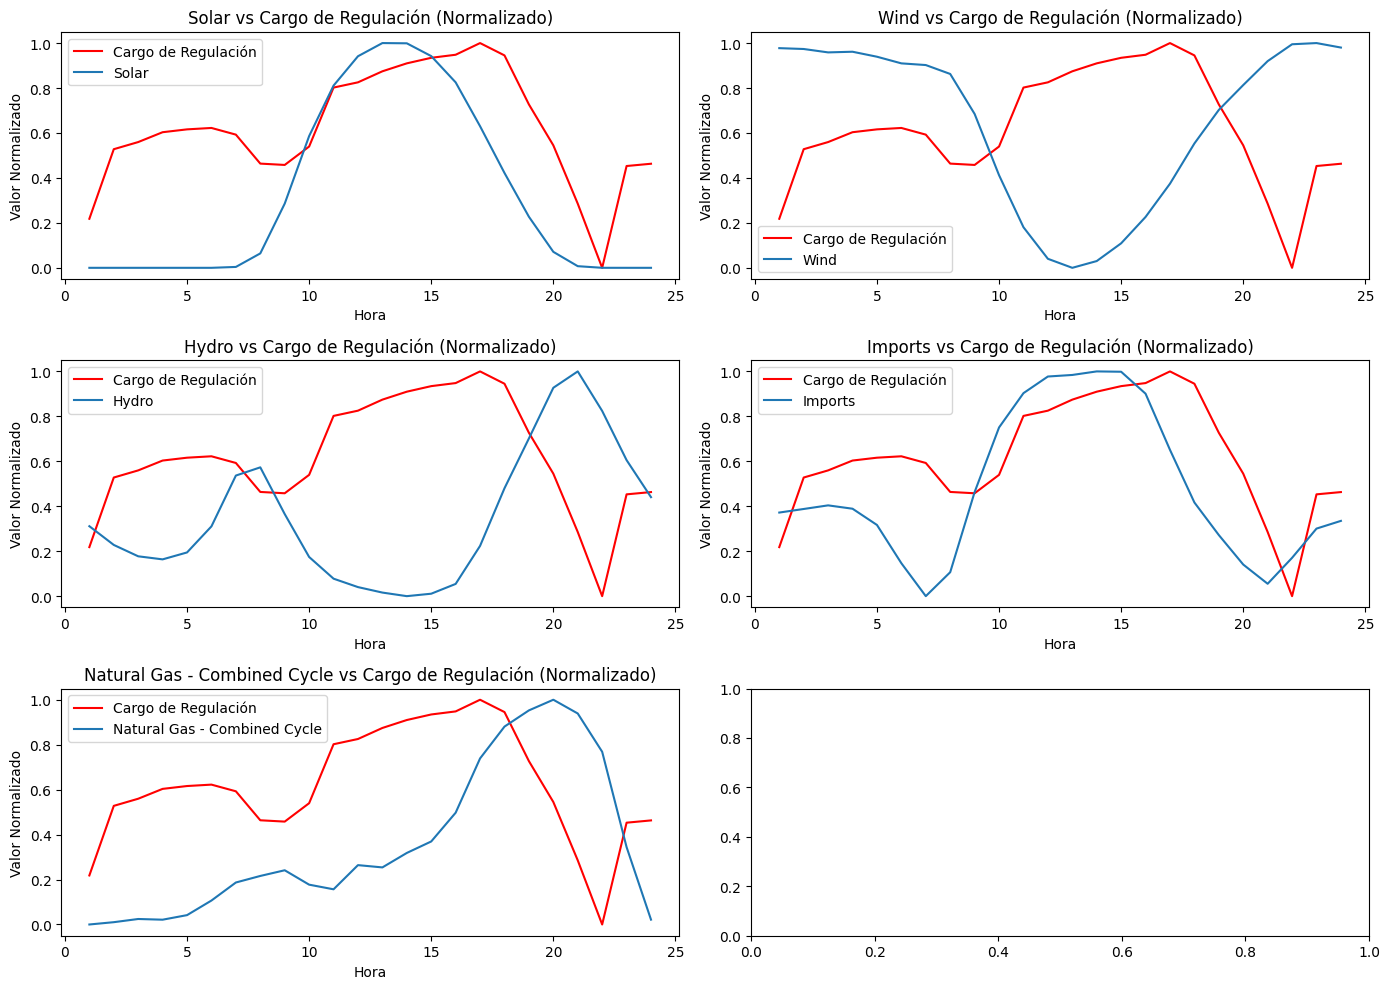

In [123]:
# Normalización de todas las columnas menos "Hora"
cols_to_normalize = ["Solar", "Wind", "Hydro", "Imports", "Natural Gas - Combined Cycle","cargo de regulación"]
scaler = MinMaxScaler()
suma_por_hora[cols_to_normalize] = scaler.fit_transform(suma_por_hora[cols_to_normalize])

# Graficar comparaciones
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
tecnologias = ["Solar", "Wind", "Hydro", "Imports", "Natural Gas - Combined Cycle"]
for i, tech in enumerate(tecnologias):
    ax = axs[i//2, i%2]
    ax.plot(suma_por_hora["Hora"], suma_por_hora["cargo de regulación"], color='red', label="Cargo de Regulación")
    ax.plot(suma_por_hora["Hora"], suma_por_hora[tech], label=tech)
    ax.set_title(f"{tech} vs Cargo de Regulación (Normalizado)")
    ax.legend()
    ax.set_xlabel("Hora")
    ax.set_ylabel("Valor Normalizado")

plt.tight_layout()
plt.show()

 La energía solar se incrementa desde las 08:00 hasta las 18:00 y su comportamiento coincide con el aumento del cargo, lo que sugiere que su variabilidad contribuye a la inestabilidad del sistema, posiblemente por errores de previsión. La generación eólica presenta un patrón opuesto al del cargo, con valores más altos cuando este es bajo, lo que indica un posible efecto estabilizador. La hidráulica no presenta una relación clara, pero su disminución en horas de la tarde podría estar relacionada con la persistencia de valores altos del cargo. Las importaciones coinciden temporalmente con los picos del cargo de regulación, lo que indica que pueden ser una respuesta a desajustes en el sistema. El ciclo combinado de gas natural tiene una evolución similar pero más atenuada, lo que sugiere un papel de respaldo programado sin impacto directo en los picos del cargo.

In [124]:
#Qué tan altas están las energías cuando el cargo está alto

def comparar_precio_fuente_adaptado(df, fuente):
    if (df[fuente] == 0).sum() > 0:
        # Si hay ceros, comparar con y sin energía
        con = df[df[fuente] > 0]
        sin = df[df[fuente] == 0]
        label_con = "con energía > 0"
        label_sin = "sin energía"
    else:
        # Si siempre hay energía, usar mediana como umbral
        umbral = df[fuente].median()
        con = df[df[fuente] > umbral]
        sin = df[df[fuente] <= umbral]
        label_con = "alta generación"
        label_sin = "baja generación"

    precio_con = con["cargo de regulación"].mean()
    precio_sin = sin["cargo de regulación"].mean()
    diferencia_abs = precio_con - precio_sin
    diferencia_pct = (diferencia_abs / precio_sin) * 100 if precio_sin != 0 else None

    return {
        "Tecnología": fuente,
        "Precio (con)": round(precio_con, 2),
        "Precio (sin/baja)": round(precio_sin, 2),
        "Diferencia (€)": round(diferencia_abs, 2),
        "Diferencia (%)": round(diferencia_pct, 2) if diferencia_pct is not None else "N/A",
        "Criterio": f"{label_con} vs {label_sin}"
    }

# Tecnologías de interés
tecnologias = ["Solar", "Wind", "Imports"]

resultados_adaptados = [comparar_precio_fuente_adaptado(df_unido, tech) for tech in tecnologias]
tabla_resultados = pd.DataFrame(resultados_adaptados)


tabla_resultados

Tecnología  Precio (con)  Precio (sin/baja)  Diferencia (€)  Diferencia (%)  \
0      Solar         99.44              39.17           60.27          153.87   
1       Wind         98.77              93.20            5.57            5.97   
2    Imports         98.74              84.80           13.95           16.45   

                             Criterio  
0      con energía > 0 vs sin energía  
1  alta generación vs baja generación  
2      con energía > 0 vs sin energía

Solar: cuando hay producción solar, el cargo de regulación es un 153.87 % más alto. Esto refuerza la idea de que, aunque la energía solar es abundante en ciertas horas, su variabilidad genera más ajustes en el sistema, elevando los costes.

Wind (eólica): el efecto es moderado. Cuando hay más generación eólica, el cargo sube solo un 5.97 %, lo que indica que es una fuente más estable y con menor impacto en la necesidad de ajustes.

Imports: la presencia de importaciones también aumenta el cargo un 16.45 %, lo que sugiere que se usan como medida reactiva cuando hay desbalances, más que como causa directa.

##Agrupación por mes del cargo y pool

Por último se quiere estudiar como es la variabilidad del cargo de regulación y del precio del mercado mayorista a lo largo del año.

In [125]:
try:
    # Agrupar por hora y sumar todas las variables numéricas
    suma_por_mes = df_unido.groupby("MES").mean(numeric_only=True).reset_index()

    # Ordenar por hora por si acaso
    suma_por_mes = suma_por_mes.sort_values("MES").reset_index(drop=True)

except NameError:
    suma_por_mes = pd.DataFrame({"Error": ["df_unido no está definido."]})

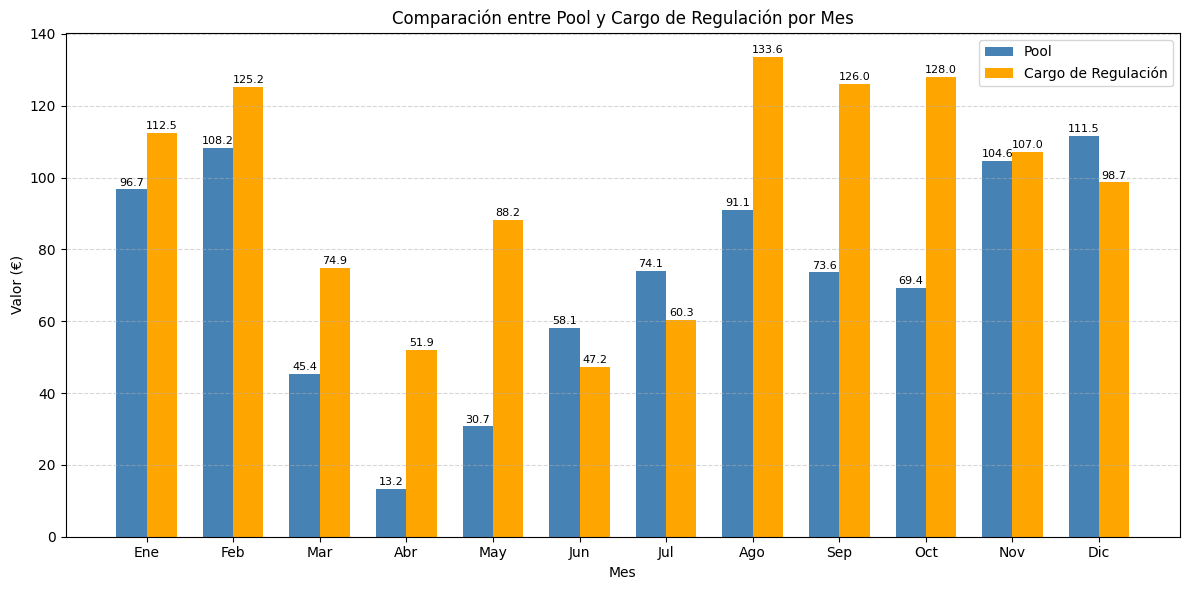

In [126]:
# Datos para el gráfico
meses = suma_por_mes.index
pool = suma_por_mes["pool"]
cargo = suma_por_mes["cargo de regulación"]

# Posiciones para las barras
x = np.arange(len(meses))
width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, pool, width, label='Pool', color='steelblue')
bars2 = plt.bar(x + width/2, cargo, width, label='Cargo de Regulación', color='orange')

# Etiquetas numéricas en las barras
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', va='bottom', fontsize=8)

mes_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
plt.xticks(x, mes_labels)
plt.xlabel("Mes")
plt.ylabel("Valor (€)")
plt.title("Comparación entre Pool y Cargo de Regulación por Mes")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

En el gráfico se observa que el cargo de regulación (barras amarillas) presenta valores notablemente más bajos entre los meses de marzo y julio. Por que durante estos meses, la generación solar es más estable gracias a la mayor duración del día y a condiciones meteorológicas más previsibles, con menor presencia de nubes y lluvias.

Respecto al precio del pool (barras azules), se aprecian los valores más bajos durante la primavera (abril y mayo), coincidiendo con una mayor penetración de renovables y una demanda relativamente moderada.

 Esto sugiere que el comportamiento del pool responde principalmente al equilibrio entre oferta y demanda, mientras que el cargo de regulación refleja más la estabilidad y previsibilidad de esa oferta.

#XGBoost

###Df REal

In [127]:
columnas_excluir = ["AÑO", "MES", "Hora"]
try:
    # Agrupar por hora
    suma_por_hora = df_unido.groupby("Hora").mean(numeric_only=True).reset_index()

    # Ordenar por hora por si acaso
    suma_por_hora = suma_por_hora.sort_values("Hora").reset_index(drop=True)

except NameError:
    suma_por_hora = pd.DataFrame({"Error": ["df_unido no está definido."]})
suma_por_hora

Hora          AÑO       MES        pool  desviacion por exceso  \
0      1  2024.199454  6.516393   81.874781              -0.403152   
1      2  2024.199454  6.516393   75.689781              -0.375120   
2      3  2024.199454  6.516393   71.915929              -0.365363   
3      4  2024.199454  6.516393   69.896557              -0.375408   
4      5  2024.199454  6.516393   68.225000              -0.379700   
5      6  2024.199454  6.516393   70.346721              -0.376166   
6      7  2024.199454  6.516393   77.634262              -0.368770   
7      8  2024.199454  6.516393   88.983770              -0.374730   
8      9  2024.199454  6.516393   89.775301              -0.427294   
9     10  2024.199454  6.516393   75.708497              -0.487871   
10    11  2024.199454  6.516393   60.789016              -0.549406   
11    12  2024.199454  6.516393   51.896913              -0.560027   
12    13  2024.199454  6.516393   48.265710              -0.575430   
13    14  2024.199454  6.516393   45.880273              -0.594147   
14    15  2024.199454  6.516393   44.175929              -0.606051   
15    16  2024.199454  6.516393   45.322350              -0.594378   
16    17  2024.199454  6.516393   50.992787              -0.582627   
17    18  2024.199454  6.516393   62.574536              -0.512715   
18    19  2024.199454  6.516393   77.573443              -0.485358   
19    20  2024.199454  6.516393   93.814126              -0.483443   
20    21  2024.199454  6.516393  103.740929              -0.450193   
21    22  2024.199454  6.516393  106.404672              -0.429233   
22    23  2024.199454  6.516393   97.756011              -0.442990   
23    24  2024.200000  6.526027   88.468000              -0.428101   

    desviacion por defecto  posicion final     conteo  cargo de regulación  \
0                 0.498403        9.480055   9.575305            57.424210   
1                 0.537932        9.229235   9.392047            87.032990   
2                 0.531796        9.137432   9.303864            90.067615   
3                 0.519753        8.977049   9.121395            94.257622   
4                 0.517146        8.941530   9.078976            95.470027   
5                 0.505416        8.977049   9.106299            96.069656   
6                 0.486200        9.057377   9.174808            93.229382   
7                 0.496456        9.668852   9.790579            80.899406   
8                 0.513944       10.263115  10.349765            80.334124   
9                 0.517850       10.917760  10.947739            88.168772   
10                0.564829       10.909563  10.924986           113.252865   
11                0.595565       10.451639  10.487178           115.481416   
12                0.608123       10.248087  10.280781           120.175890   
13                0.604746        9.706557   9.717156           123.559136   
14                0.569030        9.784699   9.747679           125.919663   
15                0.572005       10.082240  10.059868           127.218595   
16                0.537470       10.233880  10.188722           132.186689   
17                0.521494       10.377596  10.386374           126.940318   
18                0.521871       10.354918  10.391431           106.074087   
19                0.544645       10.152732  10.213935            88.673579   
20                0.531254       10.117213  10.198274            63.854613   
21                0.507221       10.065847  10.143835            36.560130   
22                0.491233       10.050546  10.098789            79.875441   
23                0.487661        9.754521   9.814081            80.841745   

    desviacion total  ...     Biomass  Natural Gas - Combined Cycle  \
0           0.095251  ...  351.712432                    347.515027   
1           0.162812  ...  351.201434                    349.509563   
2           0.166433  ...  351.415779                    352.272131   
3           0.1443

In [128]:
# 1. Cargar y procesar datos de producción
df_prod = pd.read_csv("Breakdown of Production_20250315_20250321.csv", sep=";", skiprows=2)
df_prod.rename(columns={df_prod.columns[0]: "datetime"}, inplace=True)
df_prod["datetime"] = pd.to_datetime(df_prod["datetime"])
df_prod = df_prod[(df_prod["datetime"] >= "2025-03-15") & (df_prod["datetime"] <= "2025-03-21 23:59:00")]
df_prod["Fecha_Prev"] = df_prod["datetime"].dt.strftime("%d/%m/%Y")
df_prod["Hora"] = df_prod["datetime"].dt.hour + 1
df_hourly = df_prod.groupby(["Fecha_Prev", "Hora"], as_index=False).mean(numeric_only=True)


# 2. Cargar y preparar datos BRP
df_brp = pd.read_csv("datosBRPfinal.csv", sep=";", decimal=",", encoding="utf-8")
df_brp.rename(columns=lambda c: c.replace("¢", "ó"), inplace=True)
df_brp["cargo de regulación"] = pd.to_numeric(df_brp["cargo de regulación"], errors="coerce")
df_brp["desviacion por defecto"] = pd.to_numeric(df_brp["desviacion por defecto"], errors="coerce")
df_brp["desviacion por exceso"] = pd.to_numeric(df_brp["desviacion por exceso"], errors="coerce")
df_brp["desviacion total"] = df_brp["desviacion por defecto"] + df_brp["desviacion por exceso"]

# Convertir Fecha_Prev en df_hourly al formato datetime (si no lo has hecho)
df_hourly["Fecha_Prev"] = pd.to_datetime(df_hourly["Fecha_Prev"], dayfirst=True)

# Convertir Fecha_Prev en df_brp al formato datetime también
df_brp["Fecha_Prev"] = pd.to_datetime(df_brp["Fecha_Prev"], dayfirst=True)

# Volver a pasarlo a string en formato dd/mm/yyyy en ambos DataFrames
df_hourly["Fecha_Prev"] = df_hourly["Fecha_Prev"].dt.strftime("%d/%m/%Y")
df_brp["Fecha_Prev"] = df_brp["Fecha_Prev"].dt.strftime("%d/%m/%Y")



# 3. Unir datasets
#df_brp_vars = df_brp[["Fecha_Prev", "Hora", "pool", "cargo de regulación", "desviacion total", "conteo", "desviacion por exceso", "MES", "desviacion por defecto", "posicion final", "AÑO"]]
df_real = pd.merge(df_brp, df_hourly, on=["Fecha_Prev", "Hora"], how="inner")
df_real["Hora"] = df_real["Hora"].astype(int)

# Si es un DataFrame, primero convierte a Serie con el índice = Hora
media_por_hora = suma_por_hora["cargo de regulación"]  # esto debe tener índice 0–23

# Aplicar a df_real según la columna Hora
df_real["media_cargo_por_hora"] = df_real["Hora"].map(lambda h: media_por_hora.get(h - 1))


df_real = df_real.drop(columns=["Wave", "Coal"])

df_real.head()

df_real

<ipython-input-128-8c7419c4ceff>:23: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



AÑO  MES  Fecha_Prev  Hora   pool  desviacion por exceso  \
0    2025.0  3.0  15/03/2025     1  82.26               0.000000   
1    2025.0  3.0  15/03/2025     2  66.79              -0.623664   
2    2025.0  3.0  15/03/2025     3  59.43              -0.420022   
3    2025.0  3.0  15/03/2025     4  49.71              -0.552170   
4    2025.0  3.0  15/03/2025     5  44.72              -0.531415   
..      ...  ...         ...   ...    ...                    ...   
163  2025.0  3.0  21/03/2025    20  35.00              -0.179908   
164  2025.0  3.0  21/03/2025    21  40.00              -0.263946   
165  2025.0  3.0  21/03/2025    22  35.01              -0.008340   
166  2025.0  3.0  21/03/2025    23  29.42               0.000000   
167  2025.0  3.0  21/03/2025    24  15.00               0.000000   

     desviacion por defecto  posicion final    conteo  cargo de regulación  \
0                  0.221539             8.0  8.368595            83.413790   
1                  0.000000             8.5  8.097351           120.934699   
2                  0.000000             8.4  7.964130           124.864465   
3                  0.000000             8.2  7.872537           162.657938   
4                  0.000000             8.1  7.867231           150.911791   
..                      ...             ...       ...                  ...   
163                0.000000             9.6  9.328739            78.279315   
164                0.000000             9.6  8.829542            72.390493   
165                0.000000             9.2  8.649265           106.305875   
166                0.092080             8.9  8.231130           131.615640   
167                0.254991             8.4  7.987025           133.586316   

     ...  Natural Gas - Combined Cycle  Natural Gas - Cogeneration  \
0    ...                           0.0                     174.375   
1    ...                           0.0                     174.925   
2    ...                           0.0                     176.075   
3    ...                           0.0                     176.325   
4    ...                           0.0                     176.450   
..   ...                           ...                         ...   
163  ...                         286.6                     152.450   
164  ...                         229.0                     169.350   
165  ...                         228.1                     156.600   
166  ...                         260.3                     147.475   
167  ...                         276.2                     147.900   

     Other Thermal  Imports   Exports  Pumping  Battery Injection  \
0           16.575   15.850   107.800    0.300                0.0   
1           16.175   90.975     0.000    1.725                0.0   
2           16.350    0.000   116.050  187.525                0.0   
3           16.550    0.000   177.625  438.125                0.0   
4           16.625    0.000   364.150  230.225                0.0   
..             ...      ...       ...      ...                ...   
163         14.250    0.000  2268.375    0.000                0.0   
164         13.825    0.000  2193.200    0.000                0.0   
165         14.075    0.000  1678.975    0.050                0.0   
166         14.100    0.000  1546.575  112.450                0.0   
167         14.100    0.000  1672.950  367.125                0.0   

     Battery Consumption  Consumption  media_cargo_por_hora  
0                    0.0     5953.325             57.424210  
1                    0.0     5499.225             87.032990  
2                    0.0     5180.100             90.067615  
3                    0.0     5018.100             94.257622  
4                    0.0     4940.350             95.470027  
..                   ...          ...                   ...  
163                  0.0     8541.050             88.673579  
164                  0.0     8411.525             63.854613  
165                  0.0  

##CORRELACIONES

In [129]:
max_lag = 6
df = datos_sin_outliers.copy()
variables = [col for col in df.columns if col != "Fecha_Prev"]

correlaciones_lags = pd.DataFrame(index=range(0, max_lag+1), columns=variables)

# Calcular correlaciones para cada variable y cada lag
for var in variables:
    for lag in range(0, max_lag+1):
        correlacion = df[var].shift(lag).corr(df["cargo de regulación"])
        correlaciones_lags.loc[lag, var] = correlacion

correlaciones_lags

AÑO       MES      Hora      pool desviacion por exceso  \
0  0.194565  0.021633 -0.006147  -0.12052             -0.022542   
1   0.19214   0.02197   -0.0373 -0.110033             -0.031623   
2  0.187269  0.024453 -0.054249 -0.071225             -0.039356   
3  0.181915  0.027355 -0.060231 -0.025236             -0.046446   
4    0.1762   0.03126 -0.061591  0.020297             -0.046697   
5  0.171325  0.034728 -0.061103   0.06141              -0.04425   
6   0.16398  0.040388  -0.05895  0.095912             -0.036924   

  desviacion por defecto posicion final    conteo cargo de regulación  \
0               0.057715      -0.069414 -0.057628                 1.0   
1               0.053516      -0.055758 -0.048743            0.774801   
2               0.053099      -0.041534 -0.037041            0.610632   
3               0.051434      -0.027399 -0.025715            0.482172   
4               0.049794      -0.015712 -0.014146            0.382819   
5               0.052209      -0.008979 -0.004939             0.30668   
6               0.056121      -0.004363  0.004697            0.253914   

  desviacion total  ...   Biomass Natural Gas - Combined Cycle  \
0         0.022624  ... -0.258809                     0.219298   
1         0.014699  ... -0.260249                     0.215329   
2         0.009911  ...  -0.25604                     0.194406   
3         0.004725  ... -0.250322                     0.172479   
4         0.003559  ... -0.244558                     0.158186   
5         0.006492  ... -0.239117                     0.149249   
6         0.013208  ... -0.234937                     0.144757   

  Natural Gas - Cogeneration Other Thermal   Imports   Exports   Pumping  \
0                   -0.11307      0.081358  0.045327  0.020898  0.269465   
1                  -0.105823      0.078342  0.096686 -0.023533  0.300861   
2                  -0.089287      0.076441  0.099076 -0.037293  0.285838   
3                  -0.075353      0.071616  0.068751  -0.03487  0.232468   
4                   -0.06899      0.069014  0.025368 -0.027144  0.163976   
5                  -0.065812       0.06575  -0.01849 -0.021815  0.096141   
6                  -0.066731      0.061445 -0.056508 -0.018845   0.03388   

  Battery Injection Battery Consumption Consumption  
0         -0.018005           -0.001864    0.028422  
1         -0.023719           -0.011332    0.014294  
2         -0.033465            -0.01449    0.016889  
3         -0.034786            -0.01615    0.021841  
4         -0.032943           -0.024721    0.027442  
5         -0.028408           -0.029872    0.031347  
6         -0.022142            -0.02486     0.02901  

[7 rows x 23 columns]

In [130]:
# Convertir valores a float para poder filtrar
correlaciones_lags_float = correlaciones_lags.astype(float)

# Aplicar filtro: obtener solo las correlaciones con valor absoluto > 0.1
correlaciones_filtradas_valores = correlaciones_lags_float[correlaciones_lags_float.abs() > 0.1].dropna(how='all', axis=1).dropna(how='all', axis=0)
correlaciones_filtradas_valores

AÑO      pool  cargo de regulación     Hydro      Wind     Solar  \
0  0.194565 -0.120520             1.000000 -0.115115  0.138632  0.150044   
1  0.192140 -0.110033             0.774801 -0.171815  0.125394  0.177532   
2  0.187269       NaN             0.610632 -0.164064  0.113915  0.164569   
3  0.181915       NaN             0.482172 -0.129416  0.109840  0.121930   
4  0.176200       NaN             0.382819       NaN  0.108467       NaN   
5  0.171325       NaN             0.306680       NaN  0.108599       NaN   
6  0.163980       NaN             0.253914       NaN  0.107130       NaN   

    Biomass  Natural Gas - Combined Cycle  Natural Gas - Cogeneration  \
0 -0.258809                      0.219298                   -0.113070   
1 -0.260249                      0.215329                   -0.105823   
2 -0.256040                      0.194406                         NaN   
3 -0.250322                      0.172479                         NaN   
4 -0.244558                      0.158186                         NaN   
5 -0.239117                      0.149249                         NaN   
6 -0.234937                      0.144757                         NaN   

    Pumping  
0  0.269465  
1  0.300861  
2  0.285838  
3  0.232468  
4  0.163976  
5       NaN  
6       NaN

##MODELO1

In [131]:
# Convertir Fecha_Prev a datetime
df_unido["Fecha_Prev"] = pd.to_datetime(df_unido["Fecha_Prev"], dayfirst=True)

# Ordenar por Fecha_Prev y luego por Hora (para mantener orden horario dentro del día)
df_unido = df_unido.sort_values(by=["Fecha_Prev", "Hora"]).reset_index(drop=True)


In [132]:
# 1. Usar df_unido limpio
df = datos_sin_outliers.copy().dropna()
df["Fecha_Prev"] = pd.to_datetime(df["Fecha_Prev"], dayfirst=True)
df["fecha_hora"] = df["Fecha_Prev"] + pd.to_timedelta(df["Hora"], unit="h")

# 3. Ordenar por fecha_hora (crucial)
df = df.sort_values("fecha_hora").reset_index(drop=True)

# 4. Definir X e y
X = df.drop(columns=["cargo de regulación", "Fecha_Prev", "fecha_hora"])
y = df["cargo de regulación"]

# 5. División temporal (80/20)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
fechas_test = df["fecha_hora"].iloc[split_index:]


# 4. Entrenar y predecir
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=8, random_state=42)
modelo_xgb.fit(X_train, y_train)
y_pred = modelo_xgb.predict(X_test)

# 5. Crear series alineadas
y_test = pd.Series(y_test.values, index=fechas_test)
y_pred = pd.Series(y_pred, index=fechas_test)

In [133]:
# Definir el grid de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Crear el modelo base
xgb_model = XGBRegressor(random_state=42)

# Configurar la búsqueda
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entrenar con los datos de entrenamiento
grid_search_xgb.fit(X_train, y_train)

# Resultados
print("Mejores parámetros encontrados:", grid_search_xgb.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejores parámetros encontrados: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [134]:
mae1 = mean_absolute_error(y_test, y_pred)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae1:.2f} €")
print(f"RMSE: {rmse1:.2f} €")
print(f"MSE: {mae:.2f} €")

MAE: 50.53 €
RMSE: 63.14 €
MSE: 3986.56 €


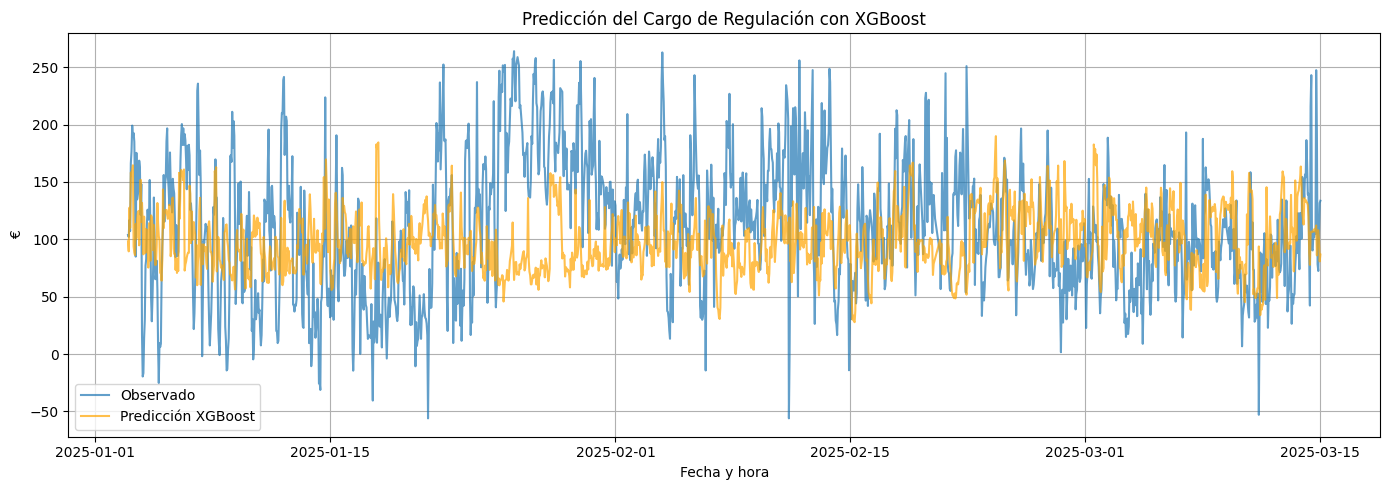

In [135]:

plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_pred.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)


plt.title("Predicción del Cargo de Regulación con XGBoost")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

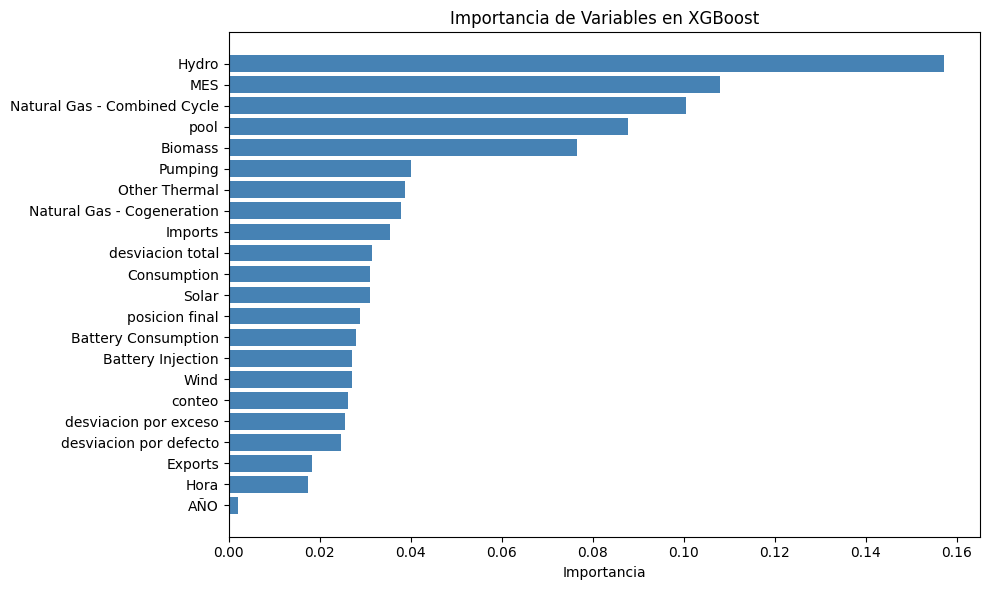

In [136]:
importances = modelo_xgb.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

<ipython-input-137-69a14c22c030>:17: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



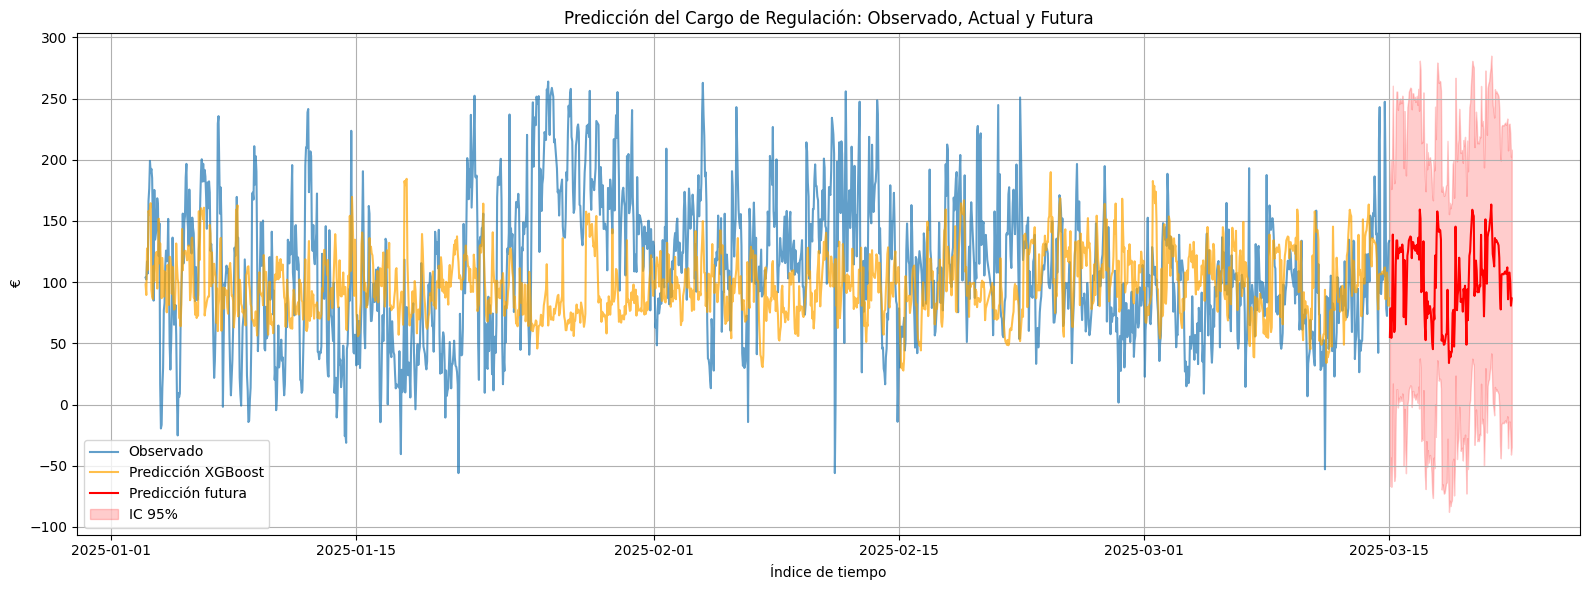

In [137]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_xgb.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=168, freq='H')

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [138]:
##REAL##
import matplotlib.dates as mdates
df_real = df_real.dropna()
# Suponiendo que tienes "Fecha_Prev" y "Hora" en df_real
df_real["Fecha_Prev"] = pd.to_datetime(df_real["Fecha_Prev"], dayfirst=True)
df_real["fecha_hora"] = df_real["Fecha_Prev"] + pd.to_timedelta(df_real["Hora"] - 1, unit="h")

X_real = df_real.drop(columns=["cargo de regulación", "Fecha_Prev", "fecha_hora", "media_cargo_por_hora"])

y_real = df_real["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

mae_real, rmse_real

# Calcular los totales para cada serie
total_real = 15559.3935
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))

                    Categoría    Total (€)     Diferencia con real (€)     Error relativo (%)
             Valor real (BRP) 15559.390000                           -                      -
  Predicción con datos reales 19554.380859                    +3994.98                +25.68%
Predicción original histórica 17318.910156                    +1759.51                +11.31%


##MODELO2

In [139]:
# Crear diccionario de medias
media_por_hora = suma_por_hora.set_index("Hora")["cargo de regulación"]

# Añadir al DataFrame principal
datos_sin_outliers["media_cargo_por_hora"] = datos_sin_outliers["Hora"].map(media_por_hora)
df["media_cargo_por_hora"] = df["Hora"].map(media_por_hora)

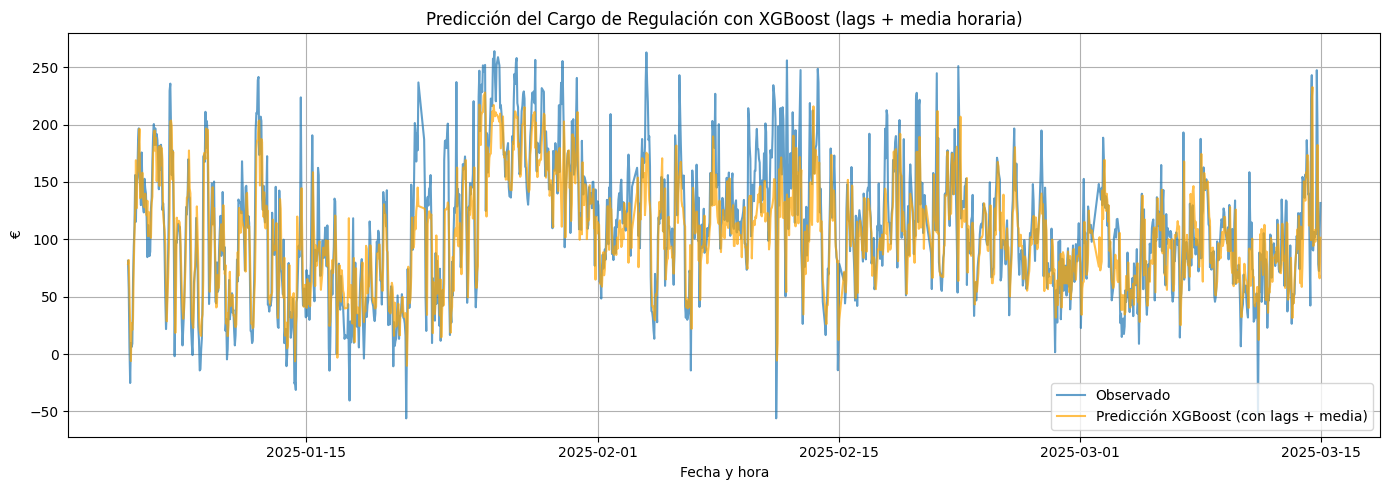

(26.453061438674716, np.float64(35.73842280804341))

In [174]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

df_modelo["Fecha_Prev"] = pd.to_datetime(df_modelo["Fecha_Prev"], dayfirst=True)
df_modelo["fecha_hora"] = df_modelo["Fecha_Prev"] + pd.to_timedelta(df_modelo["Hora"], unit="h")

# 3. Ordenar por fecha_hora (crucial)
df_modelo = df_modelo.sort_values("fecha_hora").reset_index(drop=True)


# Añadir lags más útiles según el análisis
df_modelo["Solar_t"] = df_modelo["Solar"]
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(-1)
df_modelo["Wind_t"] = df_modelo["Wind"]
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(-1)
df_modelo["pool"] = df_modelo["pool"]
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)

# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = datos_sin_outliers["media_cargo_por_hora"]

df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["Solar_t",  "pool","Solar_t-1","Wind_t",
               "cargo de regulacion_t-1", "desviacion total"]]

y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
fechas_test = df_modelo["fecha_hora"].iloc[split_index:]

# Entrenar modelo XGBoost
modelo_xgb2 = XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
modelo_xgb2.fit(X_train, y_train)
y_pred = modelo_xgb2.predict(X_test)
y_pred_train = modelo_xgb2.predict(X_train)

y_test = pd.Series(y_test.values, index=fechas_test)
y_pred = pd.Series(y_pred, index=fechas_test)

# Evaluación
mae2 = mean_absolute_error(y_test, y_pred)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
rmse3 = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae3 = mean_absolute_error(y_train, y_pred_train)

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae2, rmse2

In [141]:
# Definir el grid de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Crear el modelo base
xgb_model = XGBRegressor(random_state=42)

# Configurar la búsqueda
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entrenar con los datos de entrenamiento
grid_search_xgb.fit(X_train, y_train)

# Resultados
print("Mejores parámetros encontrados:", grid_search_xgb.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejores parámetros encontrados: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


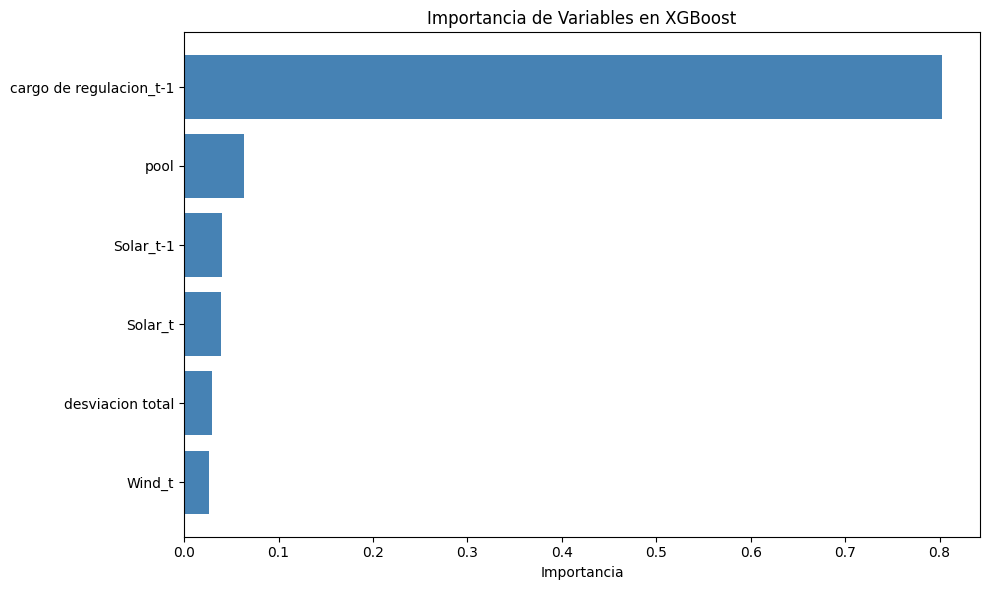

In [171]:
importances = modelo_xgb2.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

<ipython-input-175-f5b18c8bf976>:16: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



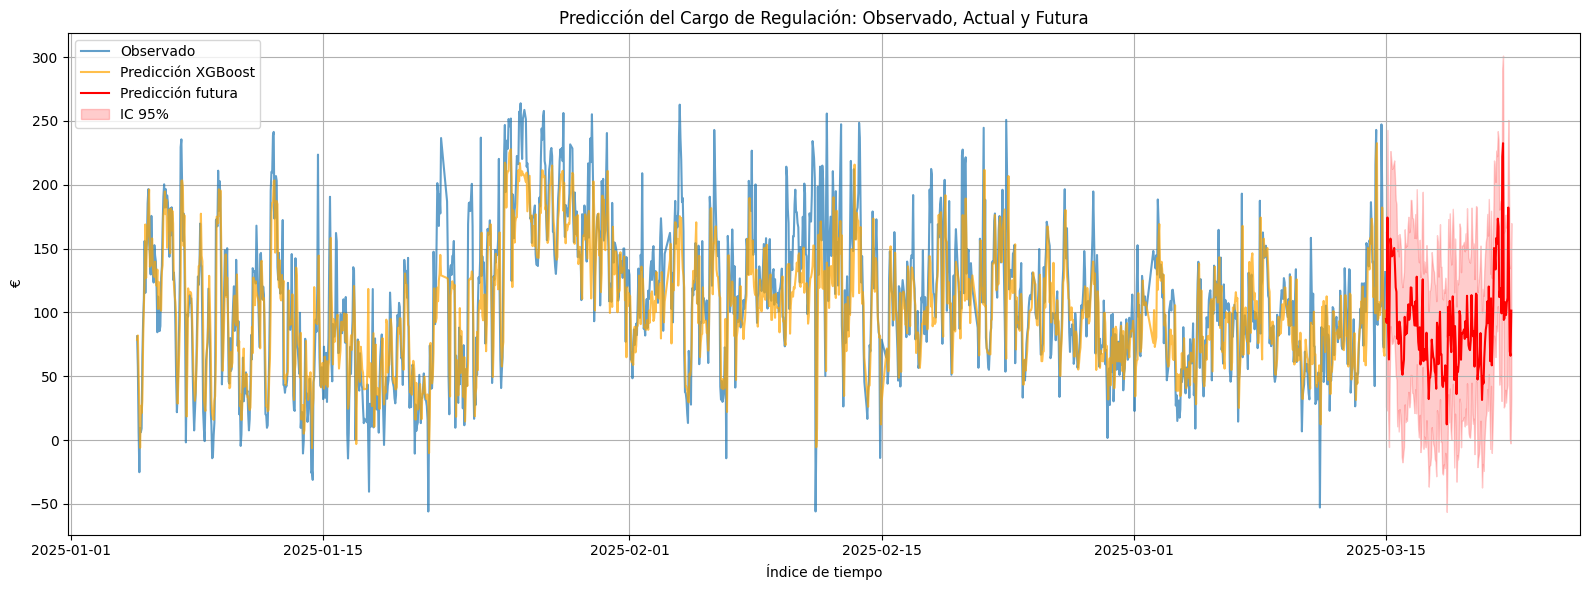

In [175]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_xgb2.predict(X_future)
last_index = y_test.index[-1]

future_index = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=168, freq='H')

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [176]:
##REAL##

df_modelo2 = df_real.copy()

# 4. Crear lags
df_modelo2["Solar_t"] = df_modelo2["Solar"]
df_modelo2["Solar_t-1"] = df_modelo2["Solar"].shift(-1)
df_modelo2["Solar_t-2"] = df_modelo2["Solar"].shift(2)
df_modelo2["Wind_t"] = df_modelo2["Wind"]
df_modelo2["Wind_t-1"] = df_modelo2["Wind"].shift(1)
df_modelo2["Imports_t"] = df_modelo2["Imports"]
df_modelo2["Imports_t-1"] = df_modelo2["Imports"].shift(1)
df_modelo2["Hydro_t-1"] = df_modelo2["Hydro"].shift(1)
df_modelo2["cargo de regulacion_t-1"] = df_modelo2["cargo de regulación"].shift(1)

# 5. Eliminar nulos por lags
df_modelo2 = df_modelo2.dropna()

# Variables predictoras y target
columnas_modelo = ["Solar_t",  "pool","Solar_t-1","Wind_t",
       "cargo de regulacion_t-1", "desviacion total"]
X_real = df_modelo2[columnas_modelo]
y_real = df_modelo2["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb2.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

mae_real, rmse_real

total_real = 15559.3935
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


                    Categoría    Total (€)     Diferencia con real (€)     Error relativo (%)
             Valor real (BRP) 15559.390000                           -                      -
  Predicción con datos reales 15424.700195                     -134.70                 -0.87%
Predicción original histórica 15057.610352                     -501.79                 -3.22%


##MODELO3

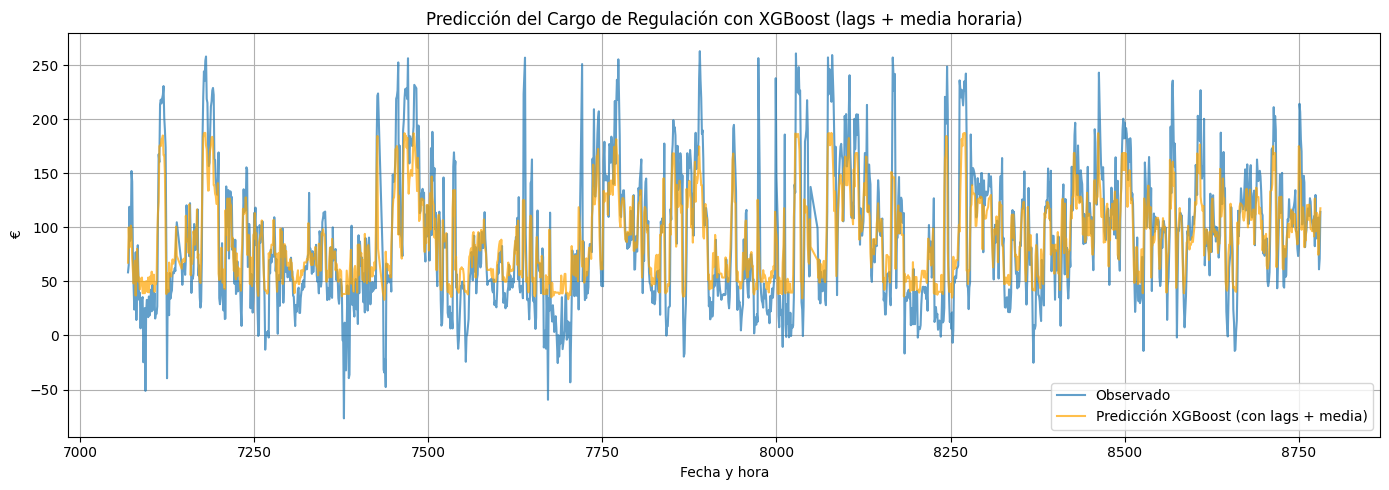

(27.516875514044067, np.float64(36.60560048124748))

In [169]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()
df_modelo["Other Thermal_t-1"] = df_modelo["Other Thermal"].shift(1)
df_modelo["Natural Gas - Cogeneration_t-1"] = df_modelo["Natural Gas - Cogeneration"].shift(1)
df_modelo["Natural Gas - Combined Cycle_t-1"] = df_modelo["Natural Gas - Combined Cycle"].shift(1)
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(-1)
df_modelo["Exports_t-1"] = df_modelo["Exports"].shift(1)
df_modelo["Pumping_t-1"] = df_modelo["Pumping"].shift(1)
df_modelo["media_cargo_por_hora"] = datos_sin_outliers["media_cargo_por_hora"]

df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["Other Thermal", "Other Thermal_t-1","Exports","Exports_t-1", "Natural Gas - Cogeneration","Natural Gas - Cogeneration_t-1",
               "Natural Gas - Combined Cycle", "Natural Gas - Combined Cycle_t-1", "pool", "cargo de regulacion_t-1",
               "media_cargo_por_hora", "Pumping"]]

y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo XGBoost
modelo_xgb3 = XGBRegressor(n_estimators=150, learning_rate=0.01, max_depth=4, random_state=42)
modelo_xgb3.fit(X_train, y_train)
y_pred = modelo_xgb3.predict(X_test)

# Evaluación
mae3 = mean_absolute_error(y_test, y_pred)
rmse3 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae3, rmse3

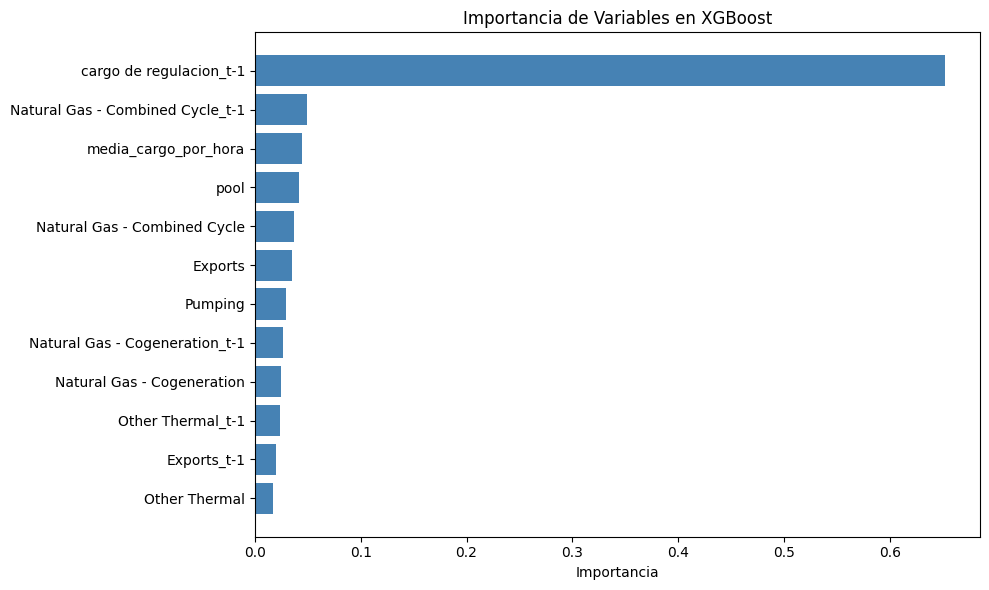

In [146]:
importances = modelo_xgb3.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

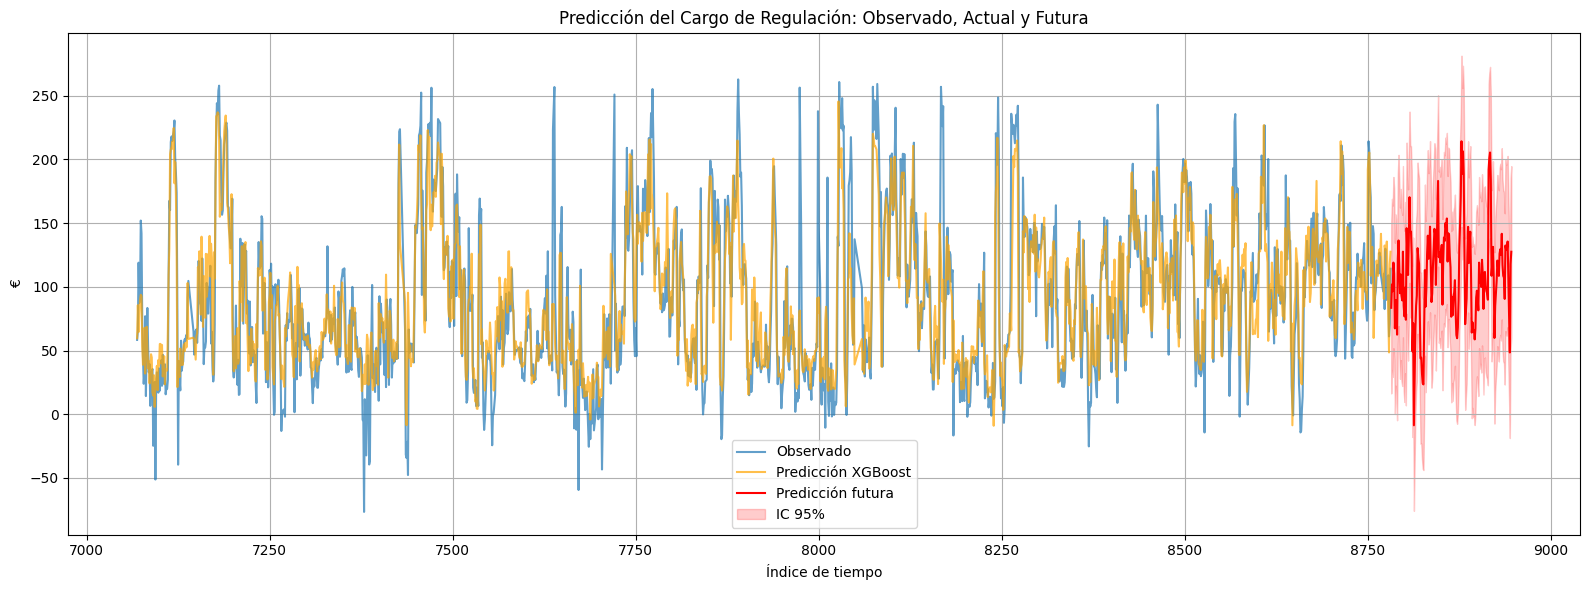

In [147]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(165).copy()
y_future_pred = modelo_xgb3.predict(X_future)
last_index = y_test.index[-1]

future_index = range(last_index + 1, last_index + 1 + 165)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [148]:
# Añadir lags más útiles según el análisis

df_modelo3=df_real.copy()
df_modelo3["Other Thermal_t-1"] = df_modelo3["Other Thermal"].shift(1)
df_modelo3["Natural Gas - Cogeneration_t-1"] = df_modelo3["Natural Gas - Cogeneration"].shift(1)
df_modelo3["Natural Gas - Combined Cycle_t-1"] = df_modelo3["Natural Gas - Combined Cycle"].shift(1)
df_modelo3["Hydro_t-1"] = df_modelo3["Hydro"].shift(1)
df_modelo3["cargo de regulacion_t-1"] = df_modelo3["cargo de regulación"].shift(-1)
df_modelo3["Exports_t-1"] = df_modelo3["Exports"].shift(1)
df_modelo3["Pumping_t-1"] = df_modelo3["Pumping"].shift(1)

df_modelo3 = df_modelo3.dropna()

# Variables predictoras y target
columnas_modelo = ["Other Thermal", "Other Thermal_t-1","Exports","Exports_t-1", "Natural Gas - Cogeneration","Natural Gas - Cogeneration_t-1",
               "Natural Gas - Combined Cycle", "Natural Gas - Combined Cycle_t-1", "pool", "cargo de regulacion_t-1",
               "media_cargo_por_hora", "Pumping"]
X_real = df_modelo3[columnas_modelo]
y_real = df_modelo3["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb3.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

# Calcular los totales para cada serie
total_real = 15559.3935
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


                    Categoría    Total (€)     Diferencia con real (€)     Error relativo (%)
             Valor real (BRP) 15559.390000                           -                      -
  Predicción con datos reales 18676.080078                    +3116.68                +20.03%
Predicción original histórica 18052.150391                    +2492.75                +16.02%


#Random Forest Regressor

##MODELO1RF

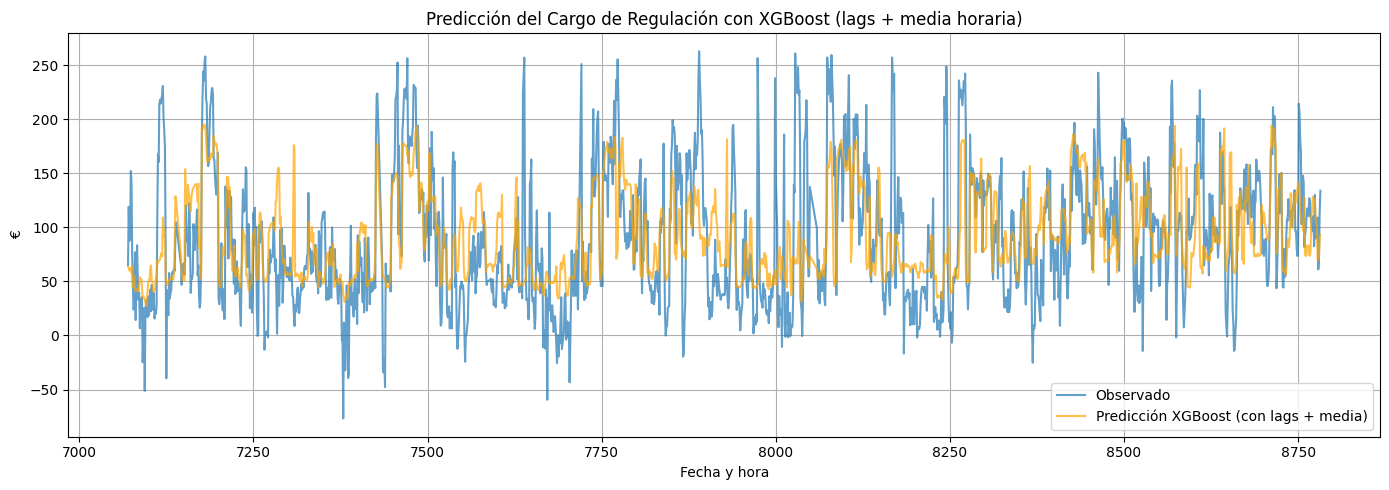

(36.07286752405896, np.float64(47.77500275952204))

In [149]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=8,
    random_state=42
)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

# Evaluación
mae6 = mean_absolute_error(y_test, y_pred)
rmse6 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae6, rmse6


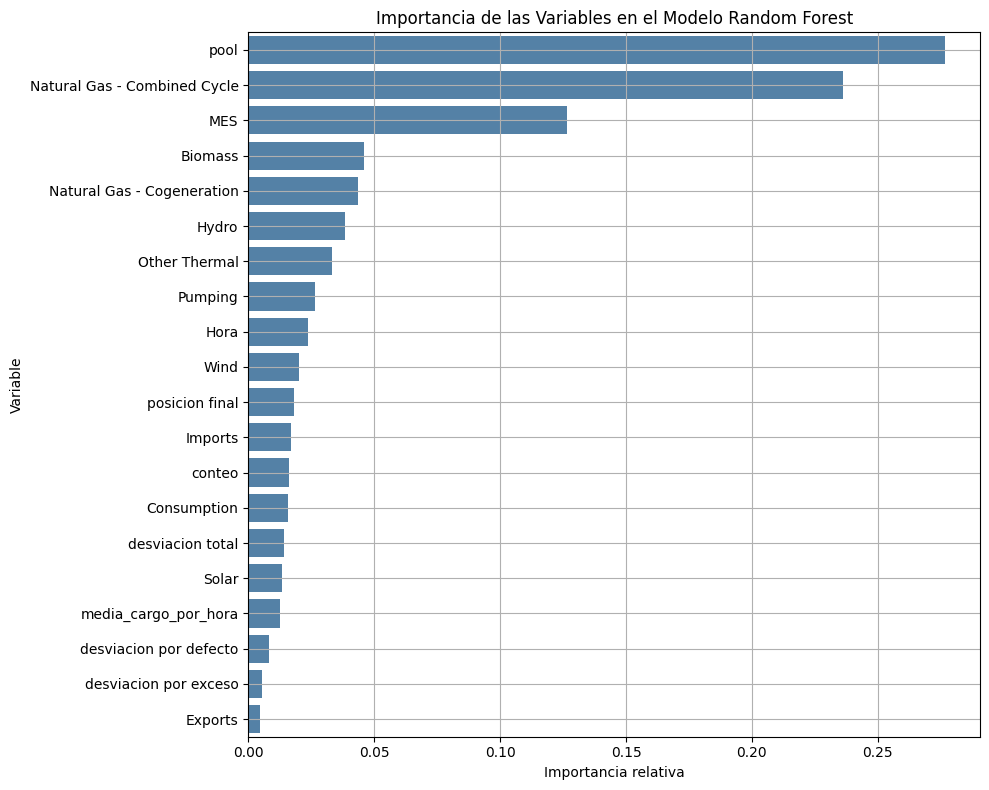

In [150]:
# Extraer la importancia de cada variable
importancias = modelo_rf.feature_importances_
nombres_columnas = X_train.columns

df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), color="steelblue")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


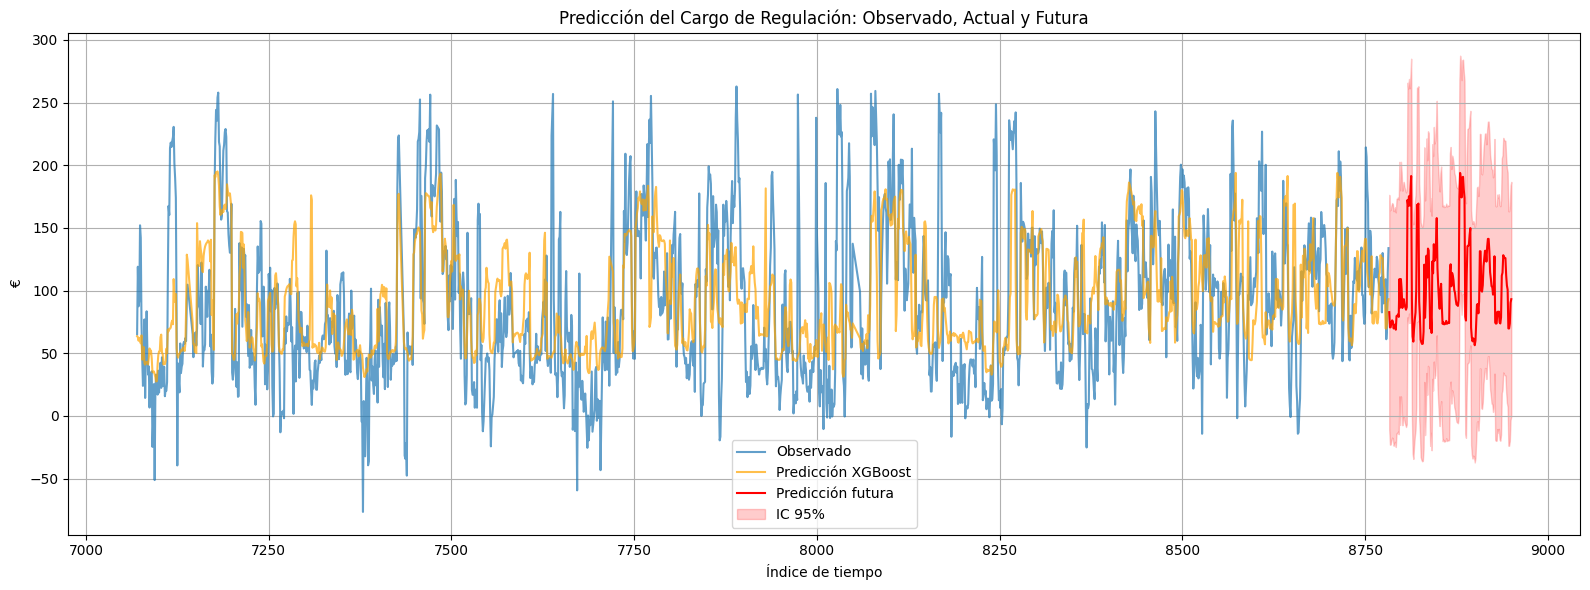

In [151]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_rf.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [152]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 14]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)


Mejores parámetros: {'max_depth': 8, 'n_estimators': 150}


In [153]:
# Añadir lags más útiles según el análisis

df_modelo4=df_real.copy()

df_modelo4 = df_modelo4.dropna()

X_real = df_modelo4.drop(columns=["cargo de regulación", "Fecha_Prev", "fecha_hora"])
y_real = df_modelo4["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_rf.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

# Calcular los totales para cada serie
total_real = 15559.3935
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


                    Categoría  Total (€)     Diferencia con real (€)     Error relativo (%)
             Valor real (BRP)   15559.39                           -                      -
  Predicción con datos reales   15576.28                      +16.89                 +0.11%
Predicción original histórica   17376.18                    +1816.79                +11.68%


##MODELO2RF

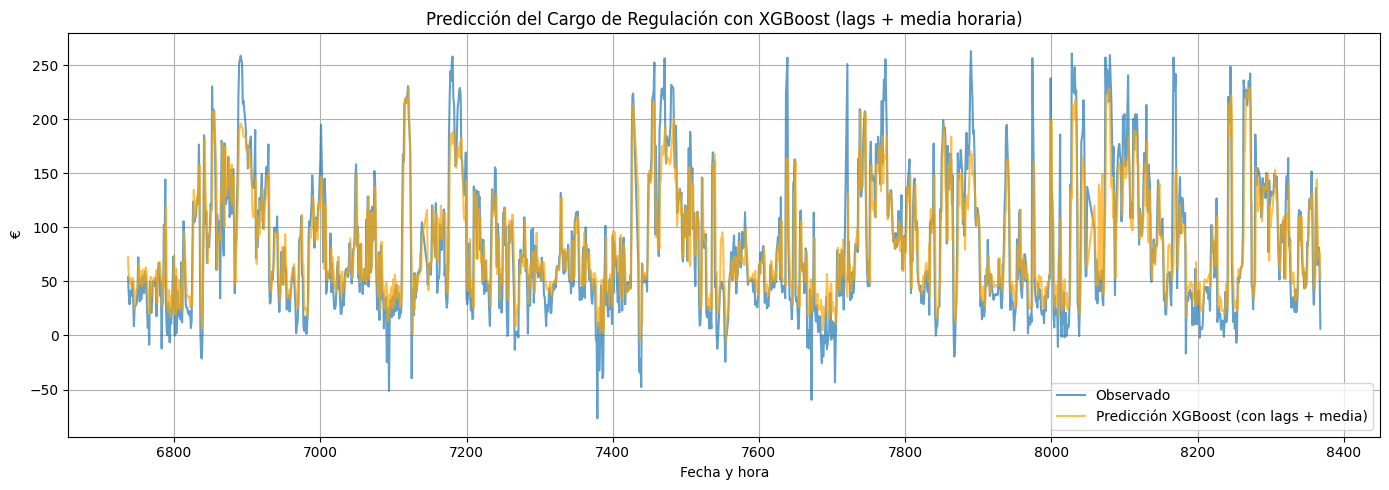

(25.150988864957622, np.float64(35.6327146904188))

In [154]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

df_modelo["Solar_t"] = df_modelo["Solar"]
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Wind_t"] = df_modelo["Wind"]
df_modelo["Wind_t-1"] = df_modelo["Wind"].shift(1)
df_modelo["Imports_t"] = df_modelo["Imports"]
df_modelo["Imports_t-1"] = df_modelo["Imports"].shift(1)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["pool"] = df_modelo["pool"]
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)

# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]
df_modelo = df_modelo.dropna()

# Variables predictoras
X = df_modelo[["Solar_t", "Solar_t-1","Solar_t-2", "Wind_t","Wind_t-1","Imports_t", "Imports_t-1", "pool",
               "Hydro_t-1", "Hydro", "cargo de regulacion_t-1", "media_cargo_por_hora", "desviacion total"]]
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf2 = RandomForestRegressor(
    n_estimators=150,
    max_depth=8,
    random_state=42
)
modelo_rf2.fit(X_train, y_train)
y_pred = modelo_rf2.predict(X_test)

# Evaluación
mae7 = mean_absolute_error(y_test, y_pred)
rmse7 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae7, rmse7


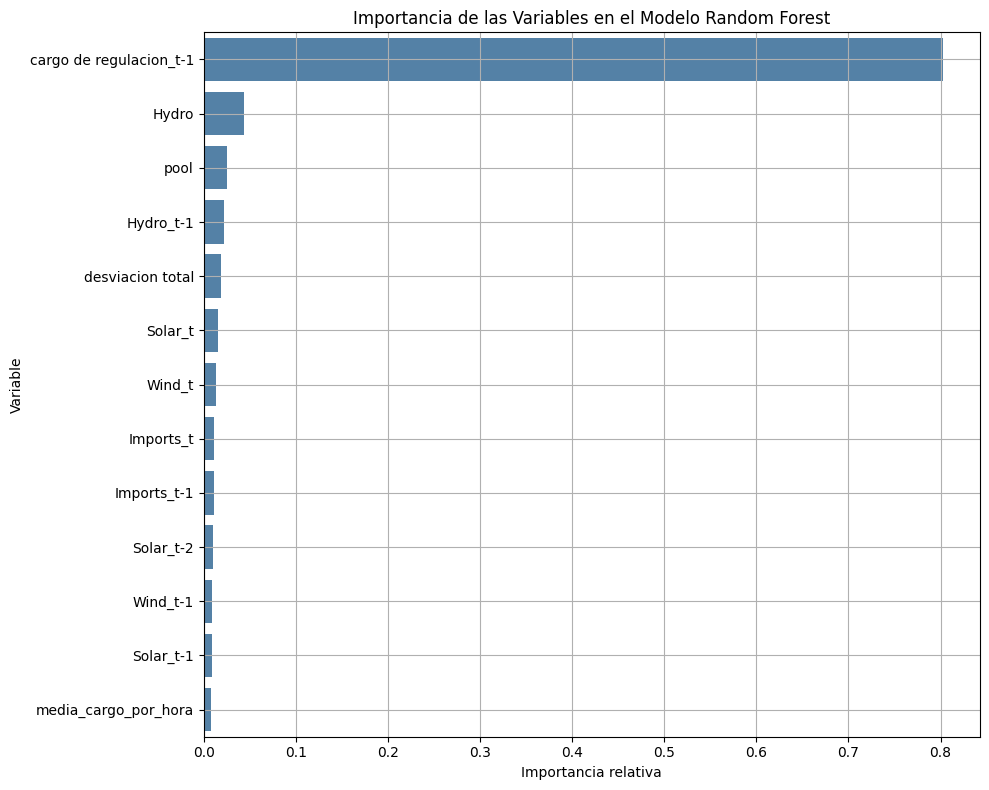

In [155]:
# Extraer la importancia de cada variable
importancias = modelo_rf2.feature_importances_
nombres_columnas = X_train.columns

df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), color="steelblue")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 14]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 8, 'n_estimators': 150}


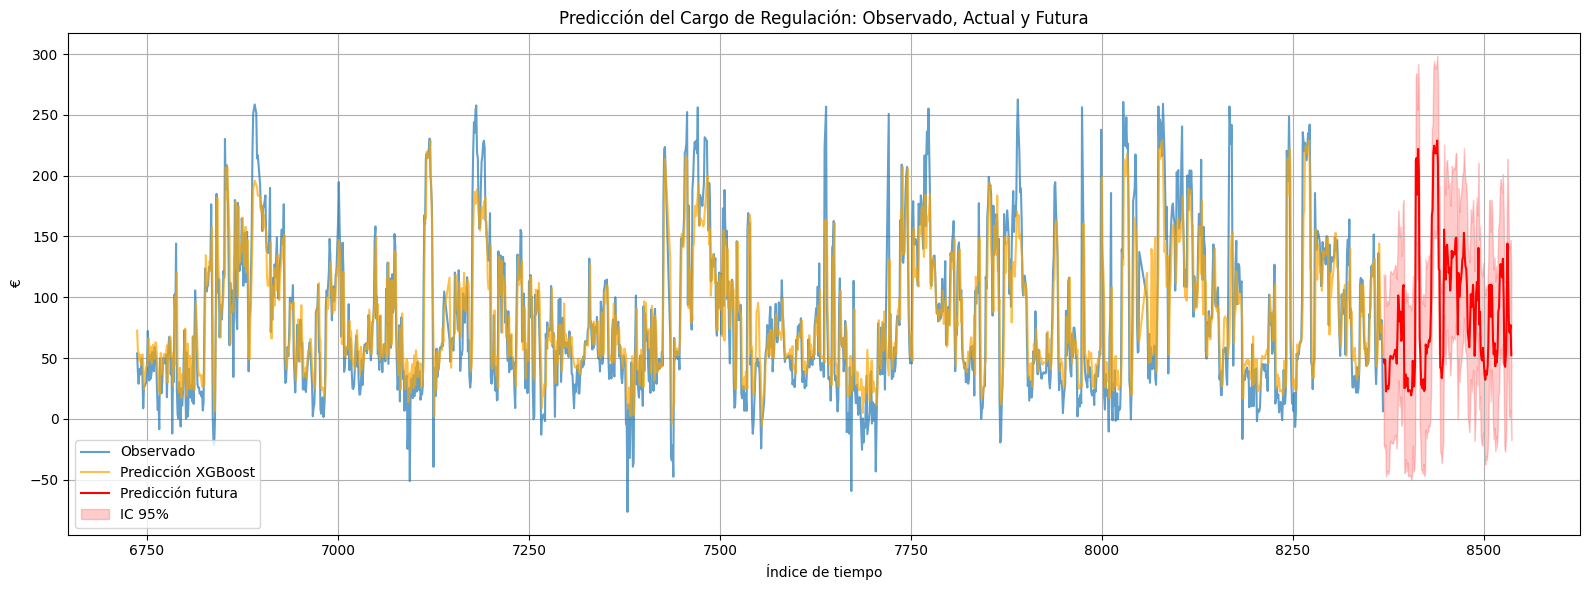

In [157]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_rf2.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [159]:
# Añadir lags más útiles según el análisis

df_modelo5=df_real.copy()

# Añadir lags más útiles según el análisis
df_modelo5["Solar_t"] = df_modelo5["Solar"]
df_modelo5["Solar_t-1"] = df_modelo5["Solar"].shift(1)
df_modelo5["Solar_t-2"] = df_modelo5["Solar"].shift(2)
df_modelo5["Wind_t"] = df_modelo5["Wind"]
df_modelo5["Wind_t-1"] = df_modelo5["Wind"].shift(1)
df_modelo5["Imports_t"] = df_modelo5["Imports"]
df_modelo5["Imports_t-1"] = df_modelo5["Imports"].shift(1)
df_modelo5["Hydro_t-1"] = df_modelo5["Hydro"].shift(1)
df_modelo5["pool"] = df_modelo5["pool"]
df_modelo5["cargo de regulacion_t-1"] = df_modelo5["cargo de regulación"].shift(1)

# Añadir la media histórica por hora
df_modelo5["media_cargo_por_hora"] = df["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo5 = df_modelo5.dropna()

# Variables predictoras
X_real = df_modelo5[["Solar_t", "Solar_t-1","Solar_t-2", "Wind_t","Wind_t-1","Imports_t", "Imports_t-1", "pool",
                "Hydro_t-1", "Hydro", "cargo de regulacion_t-1", "media_cargo_por_hora", "desviacion total"]]
y_real = df_modelo5["cargo de regulación"]


# Predicción y evaluación
y_pred_real = modelo_rf2.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

# Crear series alineadas
min_len = min(len(y_real), len(y_pred_real), len(y_future_pred))
fechas = df_modelo3.index[-min_len:]

y_real_aligned = pd.Series(y_real[-min_len:], index=fechas)
y_pred_real_aligned = pd.Series(y_pred_real[-min_len:], index=fechas)
y_future_pred_aligned = pd.Series(y_future_pred[-min_len:], index=fechas)


# Calcular los totales para cada serie
total_real = 15559.3935
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


                    Categoría  Total (€)     Diferencia con real (€)     Error relativo (%)
             Valor real (BRP)   15559.39                           -                      -
  Predicción con datos reales   14947.57                     -611.82                 -3.93%
Predicción original histórica   14632.57                     -926.82                 -5.96%


##MODELO3RF

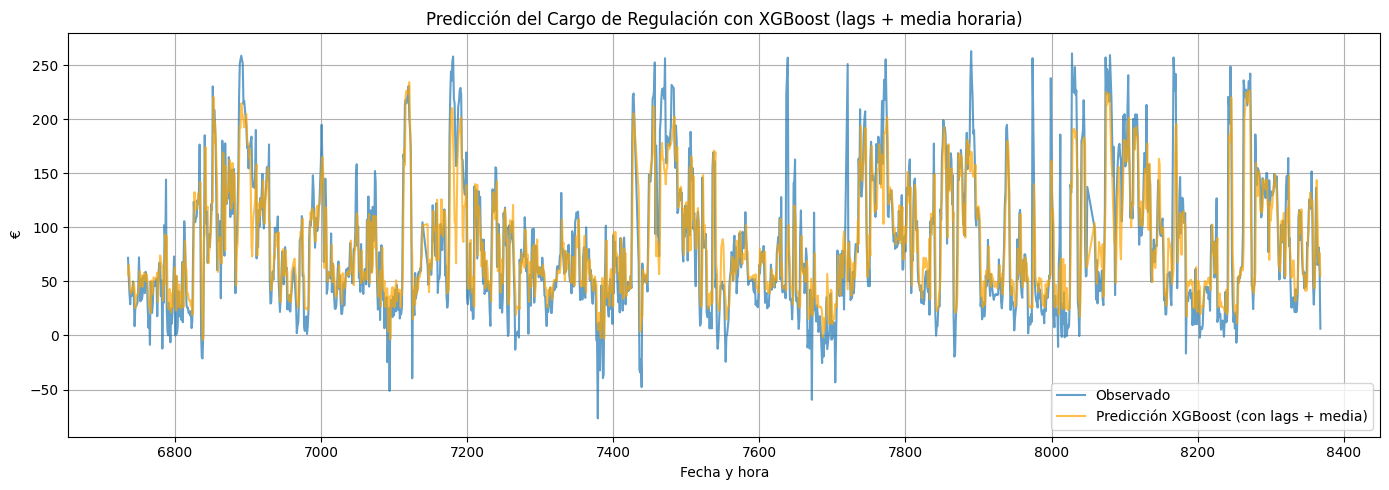

(24.4774982571709, np.float64(35.10726453731549))

In [165]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

df_modelo["Other Thermal_t-1"] = df_modelo["Other Thermal"].shift(1)
df_modelo["Natural Gas - Cogeneration_t-1"] = df_modelo["Natural Gas - Cogeneration"].shift(1)
df_modelo["Natural Gas - Combined Cycle_t-1"] = df_modelo["Natural Gas - Combined Cycle"].shift(1)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)
df_modelo["Exports_t-1"] = df_modelo["Exports"].shift(1)
df_modelo["Pumping_t-1"] = df_modelo["Pumping"].shift(1)


# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]

df_modelo = df_modelo.dropna()

# Variables predictoras
X = df_modelo[["Other Thermal", "Other Thermal_t-1","Exports","Exports_t-1", "Natural Gas - Cogeneration","Natural Gas - Cogeneration_t-1",
               "Natural Gas - Combined Cycle", "Natural Gas - Combined Cycle_t-1", "pool", "Hydro_t-1", "Hydro", "cargo de regulacion_t-1",
 "Pumping"]]
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf3 = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
modelo_rf3.fit(X_train, y_train)
y_pred = modelo_rf3.predict(X_test)

# Evaluación
mae8 = mean_absolute_error(y_test, y_pred)
rmse8 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae8, rmse8


In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 14]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 8, 'n_estimators': 200}


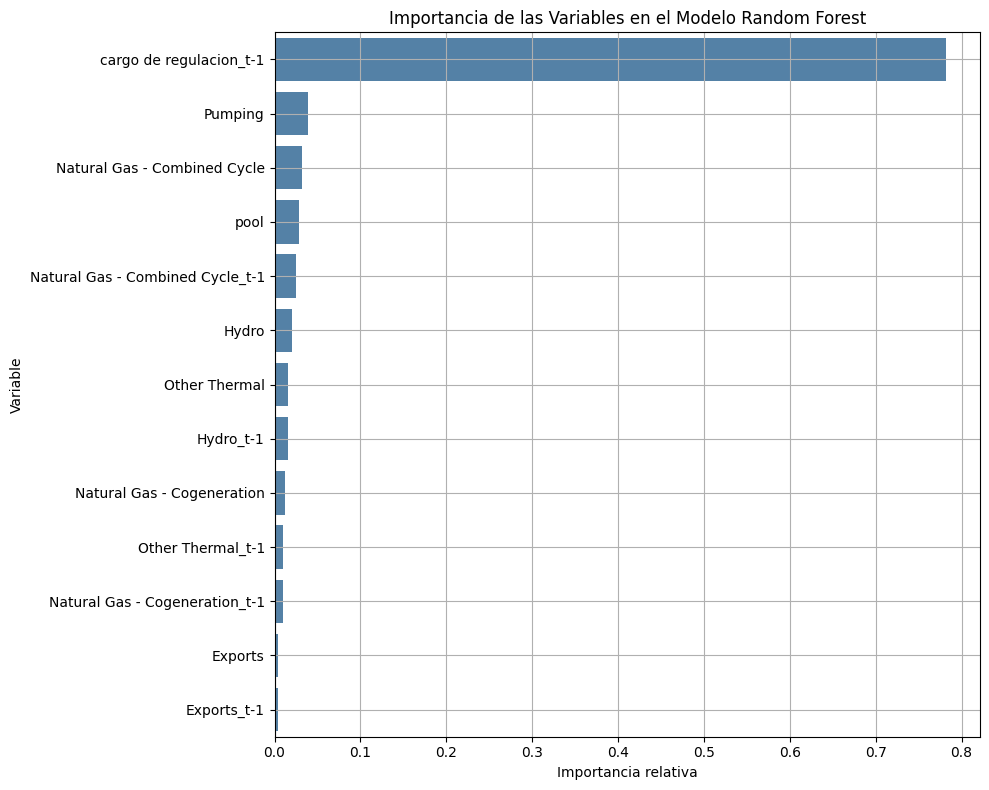

In [162]:
# Extraer la importancia de cada variable
importancias = modelo_rf3.feature_importances_
nombres_columnas = X_train.columns


df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), color="steelblue")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


In [166]:
df_modelo6=df_real.copy()

df_modelo6["Other Thermal_t-1"] = df_modelo6["Other Thermal"].shift(1)
df_modelo6["Natural Gas - Cogeneration_t-1"] = df_modelo6["Natural Gas - Cogeneration"].shift(1)
df_modelo6["Natural Gas - Combined Cycle_t-1"] = df_modelo6["Natural Gas - Combined Cycle"].shift(1)
df_modelo6["Hydro_t-1"] = df_modelo6["Hydro"].shift(1)
df_modelo6["cargo de regulacion_t-1"] = df_modelo6["cargo de regulación"].shift(1)
df_modelo6["Exports_t-1"] = df_modelo6["Exports"].shift(1)
df_modelo6["Pumping_t-1"] = df_modelo6["Pumping"].shift(1)

# Añadir la media histórica por hora
df_modelo6["media_cargo_por_hora"] = df["media_cargo_por_hora"]

df_modelo6 = df_modelo6.dropna()

# Variables predictoras
X_real = df_modelo6[["Other Thermal", "Other Thermal_t-1","Exports","Exports_t-1", "Natural Gas - Cogeneration","Natural Gas - Cogeneration_t-1",
                "Natural Gas - Combined Cycle", "Natural Gas - Combined Cycle_t-1", "pool", "Hydro_t-1", "Hydro", "cargo de regulacion_t-1", "Pumping"]]
y_real = df_modelo6["cargo de regulación"]


# Predicción y evaluación
y_pred_real = modelo_rf3.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

# Calcular los totales para cada serie
total_real = 15559.3935
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


                    Categoría  Total (€)     Diferencia con real (€)     Error relativo (%)
             Valor real (BRP)   15559.39                           -                      -
  Predicción con datos reales   15943.57                     +384.18                 +2.47%
Predicción original histórica   14632.57                     -926.82                 -5.96%
